<a href="https://colab.research.google.com/github/bbrause/movie-emotions/blob/master/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/")

In [0]:
os.chdir("./subrosa_v2")

In [0]:
import zipfile
sub_zip = zipfile.ZipFile("en.zip")
tag_zip = zipfile.ZipFile("ml-latest.zip")

In [0]:
import pandas as pd
tag_zip = zipfile.ZipFile("ml-latest.zip")
movies_movielens = pd.read_csv(tag_zip.open("ml-latest/movies.csv"))
movies_movielens = movies_movielens.set_index("movieId")
links_movielens = pd.read_csv(tag_zip.open("ml-latest/links.csv"))
links_movielens = links_movielens.set_index("movieId")

In [0]:
movies_movielens = movies_movielens.join(links_movielens)
#movies_movielens = movies_movielens.set_index("imdbId")

In [0]:
tags_movielens = pd.read_csv(tag_zip.open("ml-latest/tags.csv")).set_index("movieId")

In [0]:
import collections
import seaborn as sns

tag_dict = dict(collections.Counter([str(t).lower() for t in tags_movielens.tag]))
tag_dict = { k : v for k, v in tag_dict.items() if v > 100}
#sns.distplot(list(tag_dict.values()))

In [0]:
tags_movielens.tag = tags_movielens.tag.apply(lambda t : str(t).lower())

In [0]:
movie_tags_dict = {}

for tag in tag_dict.keys():
  movie_ids = tags_movielens[tags_movielens.tag == tag].index.values
  movie_tags_dict[tag] = dict(collections.Counter(movie_ids))

In [0]:
movie_tags_df = pd.DataFrame.from_dict(movie_tags_dict)

In [0]:
movie_tags_df = movie_tags_df.fillna(0).astype(int)

In [0]:
movie_tags_df = movie_tags_df.sort_index()

In [0]:
import pickle
ids_dfs = {}
for i in range(0, 93):
  f = pickle.load(open("sub_dataframes{:03d}.p".format(i), "rb"))
  for id_ in f.keys():
    ids_dfs[id_] = i

In [0]:
imdb_ids = []

for movie_id in movie_tags_df["scary"][movie_tags_df["scary"] > 1].index:
  imdb_ids.append(movies_movielens.loc[movie_id, "imdbId"])

imdb_ids_dfs = { id_ : ids_dfs[str(id_)] for id_ in imdb_ids if str(id_) in ids_dfs.keys()}

In [0]:
samples_df = {}

current_df_id = -1

for imdb_id, df_id in sorted(imdb_ids_dfs.items(), key = lambda item : item[1]):
  if df_id != current_df_id:
    f = pickle.load(open("sub_dataframes{:03d}.p".format(df_id), "rb"))
    current_df_id = df_id

  samples_df[imdb_id] = { 'text' : [token for l in f[str(imdb_id)].tokens.values for token in l],
                         'label' : 1}


In [0]:
imdb_ids = []

for movie_id in movie_tags_df["scary"][movie_tags_df["scary"] == 0].index:
  imdb_ids.append(movies_movielens.loc[movie_id, "imdbId"])

imdb_ids_dfs = { id_ : ids_dfs[str(id_)] for id_ in imdb_ids if str(id_) in ids_dfs.keys()}

In [0]:
current_df_id = -1

num_samples = len(samples_df) * 2

for imdb_id, df_id in sorted(imdb_ids_dfs.items(), key = lambda item : item[1])[::2]:
  if df_id != current_df_id:
    f = pickle.load(open("sub_dataframes{:03d}.p".format(df_id), "rb"))
    current_df_id = df_id

  samples_df[imdb_id] = { 'text' : [token for l in f[str(imdb_id)].tokens.values for token in l],
                         'label' : 0}

  if len(samples_df) == num_samples:
    break

In [0]:
samples_df = pd.DataFrame.from_dict(samples_df, orient='index')

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string

def dummy_fun(doc):
    return [t.lower().strip(string.punctuation + "♪" + "—") for t in doc]

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    sublinear_tf=True,
    max_df = 0.9, 
    min_df = 5)  

tfidf_df = tfidf.fit_transform(samples_df.text)

In [0]:
from sklearn.model_selection import cross_validate
svc = LinearSVC(random_state=0, tol=1e-5)
cross_validate(mnb, tfidf_df, samples_df.label, cv=5, scoring=('precision', 'recall', 'f1'))

{'fit_time': array([0.00470948, 0.0028522 , 0.00279021, 0.0027864 , 0.00282025]),
 'score_time': array([0.00588703, 0.00411534, 0.00490499, 0.00458074, 0.00492382]),
 'test_f1': array([0.57142857, 0.85714286, 0.83333333, 0.7       , 0.84615385]),
 'test_precision': array([0.66666667, 1.        , 0.76923077, 0.77777778, 0.73333333]),
 'test_recall': array([0.5       , 0.75      , 0.90909091, 0.63636364, 1.        ])}

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

mnb = MultinomialNB()
mnb.fit(pd.DataFrame(tfidf_df.todense()).set_index(samples_df.index)[samples_df.test == 0], samples_df.label[samples_df.test == 0])

rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(pd.DataFrame(tfidf_df.todense()).set_index(samples_df.index)[samples_df.test == 0], samples_df.label[samples_df.test == 0])

lrc = LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=100000)
lrc.fit(pd.DataFrame(tfidf_df.todense()).set_index(samples_df.index)[samples_df.test == 0], samples_df.label[samples_df.test == 0])

svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(pd.DataFrame(tfidf_df.todense()).set_index(samples_df.index)[samples_df.test == 0], samples_df.label[samples_df.test == 0])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [0]:
tfidf_scores_class_true = pd.DataFrame(tfidf_df.todense(), columns=tfidf.get_feature_names()).set_index(samples_df.index)[samples_df.label == 1].mean()
tfidf_scores_all = pd.DataFrame(tfidf_df.todense(), columns=tfidf.get_feature_names()).set_index(samples_df.index).mean()

In [0]:
(tfidf_scores_class_true - tfidf_scores_all).sort_values()[-100:].index

Index(['band', 'perfect', 'happy', 'whoa', 'dear', 'destiny', 'mary',
       'ridiculous', 'writing', 'charlie', 'felt', 'engaged', 'moment', 'cal',
       'annie', 'miss', 'write', 'taught', 'dating', 'exhales', 'warm',
       'goodbye', 'possibility', 'maggie', 'brilliant', 'beautiful', 'shh',
       'wine', 'clears', 'french', 'cute', 'wally', 'piano', 'meant', 'though',
       'relationship', 'dance', 'moments', 'marry', 'hammond', 'panting',
       'grunts', 'sex', 'pathetic', 'boyfriend', 'crying', 'seeing', 'sophie',
       'most', 'karen', 'engagement', 'universe', 'married', 'date', 'lonely',
       'hmm', 'heart', 'forever', '—', 'patrick', 'lovely', 'lobster',
       'letter', 'chattering', 'romantic', 'incredible', 'claire', 'mmm',
       'letters', 'person', 'la', 'chuckling', 'stars', 'dress', 'grandmother',
       'year', 'met', 'wow', 'rita', 'laughing', 'wrote', 'ooh', 'singing',
       'juliet', 'sad', 'wonderful', 'york', 'mmm-hmm', 'paris', 'sighs',
       'amazing'

In [0]:
import numpy as np

coefs = lrc.coef_[0]
coefs = rfc.feature_importances_
coefs = svc.coef_[0]

for n in np.argsort(coefs)[::-1][:100]:
  print(tfidf.get_feature_names()[n], end=", ")

ivan, crying, bastard, alright, ya, mommy, doctor, tears, cat, medicine, lying, conductor, sick, angel, bed, allow, nor, heat, franklin, suit, bail, kevin, quiet, drowned, thirsty, max, comin, human, risk, york, blown, christ, silence, good-bye, jackson, train, food, die, cloth, nick, sugar, mother, ruth, oil, richard, died, wheel, trap, music, lieutenant, outta, cold, soda, eggs, eva, drag, police, fool, crow, slick, ashamed, hadn, bitch, dynamite, wrapped, guilt, uh, crows, bored, rotten, collect, asleep, carrying, child, aren, er, nothin, fellow, 3, claim, breathing, christians, ashes, daniel, haven, pig, brat, bandits, sobbing, visit, ate, lie, coffin, drift, fires, ah, younger, scrap, hat, hurts, 

In [0]:
from sklearn.metrics import precision_recall_fscore_support

y_true = samples_df.label[samples_df.test == 1]
y_pred = mnb.predict(pd.DataFrame(tfidf_df.todense()).set_index(samples_df.index)[samples_df.test == 1])

precision_recall_fscore_support(y_true, y_pred, average='binary')

AttributeError: ignored

In [0]:
y_true

365907     1
22100      1
103644     1
105695     1
88184      1
57565      1
57358      1
104812     1
80979      1
80437      1
119349     1
120255     1
107302     1
108052     1
118583     1
119375     1
140888     1
50825      1
50613      1
40525      1
75675      1
65214      1
1531901    1
175880     1
353014     0
363226     0
366943     0
342213     0
358569     0
374330     0
327919     0
242888     0
300902     0
308152     0
312773     0
322545     0
323443     0
323807     0
328832     0
337824     0
339135     0
342150     0
346293     0
351299     0
352343     0
357474     0
365514     0
366292     0
367913     0
Name: label, dtype: int64

In [0]:

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
import numpy as np

p_values = f_classif(tfidf_df, samples_df.label)[1]

for n in np.argsort(p_values)[:30]:
  print(tfidf.get_feature_names()[n], p_values[n])

seem 6.11455828676538e-05
dark 0.00011275158514051707
area 0.00030846848340040657
light 0.00034730665697021616
system 0.000542299625644916
outside 0.0006521763497423536
okay 0.001062299080048157
learned 0.0012468307865082491
goddamn 0.0013306329747002608
close 0.0013343169325724217
please 0.002171640154865146
minutes 0.0022549631864259333
places 0.0030200371404747075
seen 0.003525800472071274
breathing 0.003968582412585214
doctors 0.0041345457387700225
crying 0.004641570991286875
shoes 0.0048675744953554125
appreciate 0.004976624387563271
signs 0.005153160619912817
losing 0.0058585123015829
sort 0.005913657654381837
usually 0.007038230569641361
week 0.007049062963141317
lasted 0.0075932603465434356
tree 0.008381908703309493
books 0.008762604479716645
experience 0.009247639432575961
pleased 0.009456156063232368
box 0.009493261183689221


In [0]:
samples_df

,text,label
304415,"[All, her, life, she, had, wanted, to, teach, ...",1
319061,"[I, deliver, perfection, ..., and, don, 't, br...",1
329388,"[Roses, ?, -, How, much, ?, -, Twenty-five, fr...",1
96787,"[Captioning, Made, Possible, By, Mgm, Home, En...",1
98384,"[Morning, ., Good, morning, ., Morning, ., Get...",1
...,...,...
98273,"[Oh, ,, baby, ., Okay, ?, I, can, 't, ..., Is,...",0
98282,"[Are, you, fucking, deaf, ?, Move, !, Are, you...",0
98308,"[To, open, up, Southern, California, 's, bigge...",0
98319,"[Hiya, ,, wall, ., Well, ,, what, 's, wrong, w...",0


In [0]:
(pd.DataFrame(tfidf_df.todense(), columns=tfidf.get_feature_names()).set_index(samples_df.index)[samples_df.label == 1].mean() - pd.DataFrame(tfidf_df.todense(), columns=tfidf.get_feature_names()).set_index(samples_df.index).mean()).sort_values()[-100:]

marry      0.002855
lonely     0.002865
buzz       0.002873
songs      0.002902
theater    0.002911
             ...   
mary       0.007678
max        0.009493
jenny      0.011288
—          0.015806
♪          0.025296
Length: 100, dtype: float64

In [0]:
samples_df

,text,label
335266,"[Lost, in, Translation, (, 2003, ), Welcome, t...",1
319061,"[I, deliver, perfection, ..., and, don, 't, br...",1
346336,"[ROME, ,, SUMMER, OF, 1966, Can, you, help, me...",1
97165,"[Now, remember, keep, your, shoulders, back, ....",1
112471,"[Do, you, have, any, idea, what, they, were, a...",1
...,...,...
410332,"[Pritam, /, Chittu, Driver, :, There, 's, a, h...",0
403990,"[Presented, by, The, Doppelganger, Production,...",0
265148,"[Today, 's, the, last, day, of, college, ., A,...",0
318988,"[ANA, AND, THE, OTHERS, -, Hello, ., -, Good, ...",0


In [0]:
len(tfidf.get_feature_names())

39093

In [0]:
for n in np.argsort(clf.coef_[0])[::-1][:20]:
  print(tfidf.get_feature_names()[n])

♪
't
#
I
:
Simon
to
Jack
'll
[
George
]
"
Forrest
MAGGIE
Murph
Wally
Akeelah
be
of


In [0]:
movies_movielens

,title,genres,imdbId,tmdbId
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...
193876,The Great Glinka (1946),(no genres listed),38566,78251.0
193878,Les tribulations d'une caissière (2011),Comedy,1754787,87558.0
193880,Her Name Was Mumu (2016),Drama,5847740,422666.0


In [0]:
sub_zip_filenames = sub_zip.namelist()
sub_zip_filenames_dict = {}
#movielens_ids = list(movies_movielens.imdbId)
for filename in sub_zip_filenames:
  if not filename.endswith("xml"):
    continue
  filename_split = filename.split("/")
  if len(filename_split) > 4:
    try:
      id_ = int(filename_split[4])
      #if id_ not in movielens_ids:
      #  continue
      if id_ not in sub_zip_filenames_dict:
        sub_zip_filenames_dict[id_] = []
      sub_zip_filenames_dict[id_].append(filename)
    except:
      pass

count = 0
"""
for i, movie in movies_movielens.iterrows():
  try:
    if int(movie.imdbId) in sub_zip_filenames_dict:
      count += 1
    else:
      pass
  except:
    pass
    
print(count)
"""

'\nfor i, movie in movies_movielens.iterrows():\n  try:\n    if int(movie.imdbId) in sub_zip_filenames_dict:\n      count += 1\n    else:\n      pass\n  except:\n    pass\n    \nprint(count)\n'

In [0]:
from lxml import etree
from datetime import timedelta
import pickle
import numpy as np
validation_scores = []
sub_zip_filenames_dict_filtered = {}
count = 0
for id_, filenames in sub_zip_filenames_dict.items():
  filenames_filtered = []
  for filename in filenames:
    f = sub_zip.open(filename)
    tree = etree.parse(f)
    #print(etree.tostring(tree.getroot(), pretty_print=True))
    try:
      cds = tree.xpath('meta/subtitle/cds')[0].text
      if cds != "1/1":
        continue
    except:
      continue
    try:
      duration_meta = int(tree.xpath('meta/source/duration')[0].text)
      if duration_meta < 40:
        continue
    except:
      duration_meta = 0
      pass
    try:
      d_ = [int(t) for t in tree.xpath('meta/subtitle/duration')[0].text.replace(",", ":").split(":")]
      duration_sub = timedelta(hours = d_[0], minutes = d_[1], seconds = d_[2], milliseconds = d_[3]).total_seconds()
      if duration_sub/60 < 40:
        continue
    except:
      duration_sub = 0
      pass
    #if abs(duration_meta - (duration_sub/60)) > 40:
    #  reasons.append("duration_diff")
    #  continue
    duration = max(duration_meta, duration_sub/60)
    if duration < 40:
      continue
    try:
      conversion = tree.xpath('meta/conversion')[0]
      tokens = int(conversion.xpath('tokens')[0].text)
      ignored_blocks = int(conversion.xpath('ignored_blocks')[0].text)
      unknown_words = int(conversion.xpath('unknown_words')[0].text)
      corrected_words = int(conversion.xpath('corrected_words')[0].text)
      if len(validation_scores) < 5000:
        validation_scores.append([(tokens/duration), (ignored_blocks/tokens), 
                                 (unknown_words/tokens), (corrected_words/tokens)])
        validation_scores_mean = np.mean(validation_scores, axis=0)
        validation_scores_std = np.std(validation_scores, axis=0)
      valid = True
      for i, score in list(enumerate([(tokens/duration), (ignored_blocks/tokens), 
                                 (unknown_words/tokens), (corrected_words/tokens)])):
        if abs(score - validation_scores_mean[i]) > 2*validation_scores_std[i]:
          valid = False
      if valid == False:
        continue
    except Exception as e:
      print(e)
      continue
    filenames_filtered.append(filename)
    break
  if len(filenames_filtered) > 0:
    sub_zip_filenames_dict_filtered[id_] = filenames_filtered
  if len(sub_zip_filenames_dict_filtered.keys()) % 100 == 0:
    print(len(sub_zip_filenames_dict_filtered.keys()))

pickle.dump(sub_zip_filenames_dict_filtered, open("subs_filtered.p", "wb"))

100
100
200
300
300


KeyboardInterrupt: ignored

###############################################################################

In [0]:
import pickle
import zipfile
subs_files = pickle.load(open("subs_filtered.p", "rb"))
sub_zip = zipfile.ZipFile("en.zip")

In [0]:
from datetime import timedelta
from lxml import etree
import re
import pandas as pd

ocr_correct_dict = {}

for key, val in subs_files.items(): 
  f = sub_zip.open(val[0])
  tree = etree.parse(f)
  blocks = [block for block in tree.xpath("s")]
  tokens = [token for block in blocks for token in block.xpath('w')]
  for token in tokens:
    if "alternative" in token.attrib:
      if token.attrib["alternative"].lower() == token.text.lower():
        continue
      if token.attrib["alternative"] not in ocr_correct_dict:
        ocr_correct_dict[token.attrib["alternative"]] = []
      ocr_correct_dict[token.attrib["alternative"]].append(token.text)
    
  #start_times = [0] * len(blocks)
  #end_times = [0] * len(blocks)

KeyboardInterrupt: ignored

In [0]:
ocr_correct_dict_corrections = [word for key, val in ocr_correct_dict.items() for word in val]
for key in list(ocr_correct_dict.keys()):
  if key in ocr_correct_dict_corrections:
    del ocr_correct_dict[key]
for word in ocr_correct_dict_corrections

In [0]:
wrong_words = [word.replace("-", "").lower() for word in ocr_correct_dict.keys()]

In [0]:
wrong_words = [word for word in wrong_words if "i" in word or "l" in word]

In [0]:
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [0]:
wrong_words = [word for word in wrong_words if word not in english_vocab and word + "g" not in english_vocab and word[:-2] not in english_vocab]

In [0]:
import pickle

with open('wrong_words.p', 'wb') as fp:
    pickle.dump(set(wrong_words), fp)

In [0]:
from datetime import timedelta
from lxml import etree
import re
import pandas as pd

sub_dataframes = {}
count = 0

for key, val in subs_files.items(): 
  f = sub_zip.open(val[0])
  tree = etree.parse(f)
  blocks = [block for block in tree.xpath("s")]
  times = [[time.attrib['value'] for time in block.xpath('time')] for block in blocks]
  times = [[[int(t) for t in re.findall('(\d+)', timestr)] for timestr in time_list] for time_list in times]
  times = [[timedelta(hours=t[0], minutes=t[1], seconds=t[2], milliseconds=t[3]) for t in time_list] for time_list in times]
  times = [sorted(t, key=lambda t: t.total_seconds()) for t in times]
  tokens = [[token.text for token in block.xpath('w')] for block in blocks]
  start_times = [0] * len(blocks)
  end_times = [0] * len(blocks)
  for i in range(0, len(blocks)):
    if len(times[i]) > 0:
      start_times[i] = times[i][0]
      end_times[i] = times[i][-1]
    else:
      start_times[i] = None
      end_times[i] = None
  sub_dataframes[str(key)] = pd.DataFrame({"start": start_times, "end": end_times, "tokens": tokens})
  if len(sub_dataframes.keys()) % 1000 == 0:
    print(len(sub_dataframes.keys()))
    pickle.dump(sub_dataframes, open("sub_dataframes{:03d}.p".format(count), "wb"))
    sub_dataframes = {}
    count += 1

Exception ignored in: <bound method ZipFile.__del__ of <zipfile.ZipFile [closed]>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/zipfile.py", line 1686, in __del__
    self.close()
  File "/usr/lib/python3.6/zipfile.py", line 1708, in close
    self._fpclose(fp)
  File "/usr/lib/python3.6/zipfile.py", line 1816, in _fpclose
    fp.close()
OSError: [Errno 107] Transport endpoint is not connected


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [0]:
pickle.dump(sub_dataframes, open("sub_dataframes{:03d}.p".format(count), "wb"))

########################################################

In [0]:
import gzip
import pandas as pd
imdb_data = pd.read_csv(gzip.open("title.basics.tsv.gz", "rb"), sep="\t")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
imdb_data = imdb_data[imdb_data.titleType.isin(["movie", "short", "tvMovie", "tvMiniSeries", "tvShort", "tvSpecial"])]

In [0]:
imdb_data.tconst = imdb_data.tconst.apply(lambda x: int(x[2:]))

In [0]:
import pickle
imdb_data_ids_ = list(imdb_data.tconst)
exclude_ids_ = []

for i in range(0, 93):
  f = pickle.load(open("sub_dataframes{:03d}.p".format(i), "rb"))
  ids_ = f.keys()
  exclude_ids_ += [id_ for id_ in ids_ if id_ not in imdb_data_ids_]

pickle.dump(exclude_ids_, open("exclude_ids_.p", "wb"))

In [0]:
imdb_data = imdb_data.set_index("tconst")

In [0]:
import matplotlib.pyplot as plt
import numpy as np

np.histogram(imdb_data[imdb_data.index.isin(subs_files.keys())][imdb_data.startYear != "\\N"].startYear.astype(int), bins=np.arange(1896, 2020, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(array([   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
           0,    0,    2,    0,    5,    3,    6,    5,    7,    8,   10,
           7,   16,   14,   10,   17,   10,   15,   20,   16,   21,   21,
          22,   56,   94,  112,  123,  120,  136,  116,  110,   93,  119,
         115,  120,  124,  126,  109,  109,  113,  137,  165,  154,  174,
         158,  157,  175,  178,  220,  197,  222,  228,  220,  254,  223,
         258,  252,  275,  289,  301,  354,  351,  342,  352,  369,  381,
         366,  362,  348,  357,  329,  339,  342,  335,  324,  326,  376,
         353,  371,  373,  387,  422,  411,  398,  411,  402,  439,  433,
         470,  506,  534,  588,  637,  734,  801,  925, 1044, 1195, 1159,
        1324, 1419, 1516, 1571, 1630, 1788, 1801, 1921, 1937, 1870, 1659,
         508,    4]),
 array([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906,
        1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
        1918, 19

########################################################

In [0]:
import pickle
exclude_ids_ = pickle.load(open("exclude_ids_.p", "rb"))

In [0]:
genome_tags_movielens = pd.read_csv(tag_zip.open("ml-latest/genome-tags.csv"))
genome_scores_movielens = pd.read_csv(tag_zip.open("ml-latest/genome-scores.csv"))

In [0]:
movie_ids = set(list(genome_scores_movielens.movieId))
tag_ids = set(list(genome_scores_movielens.tagId))

In [0]:
import numpy as np
import pandas as pd
genome_df = pd.DataFrame(np.zeros((len(movie_ids), len(tag_ids))), index=movie_ids, columns=tag_ids)

In [0]:
genome_df = genome_df.sort_index()

In [0]:
for i in tag_ids:
  if i % 10 == 0:
    print(i)
  genome_df.loc[:, i] = genome_scores_movielens[genome_scores_movielens.tagId == i].sort_values(by=['movieId']).set_index('movieId').relevance

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120


In [0]:
movies_movielens

,title,genres,imdbId,tmdbId
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...
193876,The Great Glinka (1946),(no genres listed),38566,78251.0
193878,Les tribulations d'une caissière (2011),Comedy,1754787,87558.0
193880,Her Name Was Mumu (2016),Drama,5847740,422666.0


In [0]:
########## TEST CLASSIFICATION ####

In [0]:
genome_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,0.58700,0.09425,0.17800,0.00700,0.03525,0.21450,0.01350,0.09725,0.66825,0.25725,0.35725,0.30225,0.04975,0.01300,0.07475,0.07050,0.13050,0.10525,0.90700,0.60850,0.03700,0.23675,0.30075,0.06200,0.03450,0.27325,0.11775,0.00750,0.02200,0.01450,...,0.14225,0.48100,0.34225,0.52750,0.36600,0.01325,0.07950,0.06675,0.04925,0.13125,0.00375,0.12100,0.27650,0.01675,0.02425,0.42850,0.06725,0.01175,0.02450,0.60275,0.09600,0.04400,0.05975,0.03725,0.10700,0.71175,0.08250,0.10025,0.05325,0.07450,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,0.08900,0.09800,0.16325,0.00650,0.00450,0.02825,0.01100,0.11950,0.62400,0.37350,0.51525,0.50100,0.20875,0.26200,0.08800,0.19500,0.14375,0.05300,0.97800,0.12375,0.01100,0.07875,0.06850,0.07525,0.05600,0.23675,0.06175,0.01875,0.02725,0.01500,...,0.08100,0.41150,0.22125,0.18750,0.35200,0.01875,0.05225,0.03450,0.02600,0.05275,0.00450,0.03875,0.19225,0.01525,0.01825,0.38950,0.09450,0.02600,0.01300,0.31100,0.08725,0.06500,0.02125,0.27025,0.38625,0.21475,0.20075,0.13150,0.01650,0.06500,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,0.02850,0.05900,0.08550,0.00475,0.00525,0.03500,0.00700,0.10750,0.15400,0.15025,0.24525,0.19000,0.10250,0.01725,0.05200,0.07350,0.09225,0.09675,0.32050,0.09725,0.01275,0.03400,0.05950,0.05925,0.03050,0.15925,0.05575,0.02975,0.04100,0.01825,...,0.10325,0.13175,0.19550,0.11925,0.04925,0.01700,0.05450,0.03225,0.02875,0.07225,0.01875,0.04525,0.15800,0.53250,0.02675,0.24075,0.06800,0.01850,0.03825,0.13450,0.14475,0.04075,0.02475,0.01675,0.02900,0.21775,0.02125,0.32325,0.02250,0.06875,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,0.02750,0.03375,0.07750,0.01075,0.00325,0.02650,0.01700,0.13775,0.13950,0.11500,0.51350,0.45850,0.10775,0.01625,0.06850,0.05725,0.06500,0.68975,0.14650,0.10475,0.01375,0.03500,0.04875,0.03325,0.02300,0.07700,0.11075,0.00900,0.01300,0.00500,...,0.09725,0.13400,0.18575,0.12875,0.05750,0.02950,0.03925,0.03075,0.01875,0.05700,0.01325,0.01950,0.31650,0.07650,0.02425,0.22025,0.06450,0.01975,0.01675,0.15250,0.04950,0.15125,0.03350,0.02075,0.03850,0.11450,0.02600,0.97625,0.01775,0.28200,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,0.02825,0.03175,0.05675,0.00825,0.00300,0.02425,0.01425,0.14725,0.14475,0.17400,0.25750,0.18800,0.08575,0.02075,0.04025,0.05400,0.11775,0.13225,0.15250,0.10200,0.01200,0.03350,0.07025,0.02575,0.03525,0.05500,0.04100,0.02525,0.05175,0.00600,...,0.08950,0.14425,0.16875,0.12450,0.06050,0.01475,0.05650,0.03275,0.02725,0.07200,0.00525,0.02475,0.13350,0.64450,0.01875,0.29300,0.05425,0.01450,0.02350,0.17000,0.09475,0.06850,0.02700,0.02125,0.03450,0.10700,0.02900,0.30650,0.01875,0.07625,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,0.04800,0.06550,0.58450,0.01300,0.00375

###########

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

#cluster_seeds = ["Toy Story (1995)", "Titanic (1997)", "Alien (1979)", "Dark Knight, The (2008)", "Truman Show, The (1998)", "Birds, The (1963)", 
#                 "Matrix, The (1999)", "Dancer in the Dark (2000)", "Drive (2011)", "Lord of the Rings (2001)", "King of Comedy, The (1982)", "Finding Nemo (2003)",
#                 "Up in the Air (2009)", "Mulholland Drive (2001)", "Where the Wild Things are (2009)", "Hable con ella (2002)"]
cluster_seeds = [114709,
78748,
56869,
120382,
120338,
133093,
168629,
468569,
780504,
120737,
85794,
266543,
1193138,
166924,
386117,
287467]
cluster_seeds = [133093, 120737, 120338, 114709, 56869, 166924, 78748, 120382]

clusters = {}

ids = []

for movie in cosine_similarity(genome_df):
  if movies_movielens.loc[genome_df.iloc[np.argmax(movie)].name, "imdbId"] not in cluster_seeds:
      continue
  imdb_id = movies_movielens.loc[genome_df.iloc[np.argmax(movie)].name, "imdbId"]
  clusters[imdb_id] = []
  ids.append(imdb_id)
  for i in reversed(np.argsort(movie)[-20:-1]):
    imdb_id_sim = movies_movielens.loc[genome_df.iloc[i].name, "imdbId"]
    if len(clusters[imdb_id]) < 19:
      if imdb_id_sim not in ids and imdb_id_sim in ids_dfs:
        clusters[imdb_id].append(imdb_id_sim)
        ids.append(imdb_id_sim)

In [0]:
ids = []
for cluster_id in clusters.keys():
  if cluster_id in ids:
    print(cluster_id)
  else:
    ids.append(cluster_id)
  print("####")
  print(movies_movielens[movies_movielens.imdbId == cluster_id]["title"].values[0], end='')
  for id_ in clusters[cluster_id]:
    if id_ in ids:
      print(id_)
    else:
      ids.append(id_)
    print(", ", end="")
    print(movies_movielens[movies_movielens.imdbId == id_]["title"].values[0], end='')
  print(" ")

####
Toy Story (1995), Monsters, Inc. (2001), Toy Story 2 (1999), Bug's Life, A (1998), Toy Story 3 (2010), Finding Nemo (2003), Ratatouille (2007), Incredibles, The (2004), Up (2009), Ice Age (2002) 
####
Alien (1979), Aliens (1986), Thing, The (1982), Close Encounters of the Third Kind (1977), Thing from Another World, The (1951), Forbidden Planet (1956), Invasion of the Body Snatchers (1978), District 9 (2009), Abyss, The (1989), Jaws (1975) 
####
Birds, The (1963), Psycho (1960), Vertigo (1958), Rope (1948), Rear Window (1954), Shadow of a Doubt (1943), Play Misty for Me (1971), Diabolique (Les diaboliques) (1955), Vanishing, The (Spoorloos) (1988), Strangers on a Train (1951) 
####
Truman Show, The (1998), Pleasantville (1998), Being There (1979), Groundhog Day (1993), Three Billboards Outside Ebbing, Missouri (2017), Black Mirror: White Christmas (2014), Fisher King, The (1991), George Carlin: Life Is Worth Losing (2005), Room (2015), Stranger than Fiction (2006) 
####
Titanic (1

In [0]:
for id_, similar in test_clusters.items():
  print("----")
  print(movies_movielens[movies_movielens.imdbId == id_]["title"])
  for id_ in similar[:20]:
    print(movies_movielens[movies_movielens.imdbId == id_]["title"])

----
movieId
1214    Alien (1979)
Name: title, dtype: object
movieId
1214    Alien (1979)
Name: title, dtype: object
movieId
1200    Aliens (1986)
Name: title, dtype: object
movieId
2288    Thing, The (1982)
Name: title, dtype: object
movieId
3471    Close Encounters of the Third Kind (1977)
Name: title, dtype: object
movieId
2660    Thing from Another World, The (1951)
Name: title, dtype: object
movieId
1301    Forbidden Planet (1956)
Name: title, dtype: object
movieId
7001    Invasion of the Body Snatchers (1978)
Name: title, dtype: object
movieId
70286    District 9 (2009)
Name: title, dtype: object
movieId
1127    Abyss, The (1989)
Name: title, dtype: object
movieId
1387    Jaws (1975)
Name: title, dtype: object
movieId
2664    Invasion of the Body Snatchers (1956)
Name: title, dtype: object
movieId
3527    Predator (1987)
Name: title, dtype: object
movieId
68237    Moon (2009)
Name: title, dtype: object
movieId
4966    Incredible Shrinking Man, The (1957)
Name: title, dtype: objec

In [0]:
pickle.dump(clusters, open("test_cluster.p", "wb"))

In [0]:
test_clusters = clusters

In [0]:

import pickle
test_clusters = pickle.load(open("test_cluster.p", "rb"))

In [0]:
import re
import numpy as np
import pickle
from scipy.interpolate import interp1d

test_clusters_ids_ = [int(id_) for key, cluster in test_clusters.items() for id_ in cluster]
test_clusters_speechtempos = {}

for i in range(0, 93):
  f = pickle.load(open("sub_dataframes{:03d}.p".format(i), "rb"))
  for id_, sub_df in f.items():
    if int(id_) not in test_clusters_ids_:
      continue

    start_times = list(sub_df.start)
    end_times = list(sub_df.end)

    for i in range(0, len(start_times)):
      if pd.isnull(start_times[i]):
        for j in range(i+1, len(start_times)):
          if not pd.isnull(start_times[j]):
            if not pd.isnull(end_times[i-1]):
              min_ = min(end_times[i-1], start_times[j])
              max_ = max(end_times[i-1], start_times[j])
            else:
              min_ = min(start_times[i-1], start_times[j])
              max_ = max(start_times[i-1], start_times[j])
            diff = max_ - min_
            start_times[i] = (min_ + diff/(j-i))
    
    sub_df.start = start_times
    sub_df = sub_df.sort_values(by="start")
    start_times = list(sub_df.start)
    end_times = list(sub_df.end)

    for i in range(0, len(end_times)):
      if pd.isnull(end_times[i]):
        for j in range(i+1, len(end_times)):
          if not pd.isnull(end_times[j]):
              min_ = min(end_times[i-1], end_times[j])
              max_ = max(end_times[i-1], end_times[j])
              diff = max_ - min_
              if (min_ + diff/(j-i)) >= start_times[i]:
                end_times[i] = (min_ + diff/(j-i))
              else:
                end_times[i] = start_times[i]
      if i < len(end_times) - 1:
        if end_times[i] > start_times[i+1]:
          temp = start_times[i+1]
          start_times[i+1] = end_times[i]
          end_times[i] = temp

    sub_df.end = end_times

    tokens = sub_df.tokens
    tokens = [[re.sub("(\W)", "", token) for token in token_block] for token_block in tokens]
    tokens = [[token for token in token_block if len(token) > 0] for token_block in tokens]
    tokens_n = [len(token_block) for token_block in tokens]
    start_times = list(sub_df.start)
    end_times = list(sub_df.end)

    X = []
    Y = []
    window_durations = []

    for i in range(0, len(tokens)):
      if i == 0:
        start_time = 0
      else:
        try:
          start_time = end_times[i-1].total_seconds()
        except:
          start_time = start_times[i].total_seconds()
      if i == len(tokens) - 1:
        end_time = end_times[i].total_seconds()
      else:
        try:
          end_time = start_times[i+1].total_seconds()
        except:
          end_time = end_times[i].total_seconds()

      X.append((start_time + end_time)/2)
      window_durations.append(abs((end_time - start_time)))
      
    X = [0] + [(sum(X[i:i+3])/3) for i in range(0, len(X)-2, 3)]
    Y = [0] + [(sum(tokens_n[i:i+3])/sum(window_durations[i:i+3])) for i in range(0, len(tokens_n)-2, 3)]
    film_duration = int(np.ceil(X[-1]))-1
    x_interp = np.arange(0, film_duration, 1)
    y_interp = interp1d(X, Y, kind="linear")(x_interp)

    test_clusters_speechtempos[id_] = {"x": x_interp,
                                       "y": y_interp}
    print(".", end="", flush=True)


KeyboardInterrupt: ignored

In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.6MB/s 


In [0]:
import re
import numpy as np
import pickle
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.interpolate import interp1d

def running_mean(x, N):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / float(N)

test_clusters_ids_ = [int(id_) for key, cluster in test_clusters.items() for id_ in cluster]
test_clusters_sentiments = {}
test_clusters_speechtempos = {}
vader = SentimentIntensityAnalyzer()

for i in range(0, 93):
  f = pickle.load(open("sub_dataframes{:03d}.p".format(i), "rb"))
  for id_, sub_df in f.items():
    if int(id_) not in test_clusters_ids_:
      continue

    start_times = list(sub_df.start)
    end_times = list(sub_df.end)

    for i in range(0, len(start_times)):
      if pd.isnull(start_times[i]):
        for j in range(i+1, len(start_times)):
          if not pd.isnull(start_times[j]):
            if not pd.isnull(end_times[i-1]):
              min_ = min(end_times[i-1], start_times[j])
              max_ = max(end_times[i-1], start_times[j])
            else:
              min_ = min(start_times[i-1], start_times[j])
              max_ = max(start_times[i-1], start_times[j])
            diff = max_ - min_
            start_times[i] = (min_ + diff/(j-i))
            break

    sub_df.start = start_times
    sub_df = sub_df.sort_values(by="start")
    start_times = list(sub_df.start)
    end_times = list(sub_df.end)

    for i in range(0, len(end_times)):
      if pd.isnull(end_times[i]):
        end_times[i] = start_times[i]
      if i < len(end_times) - 1:
        if end_times[i] > start_times[i+1]:
          temp = start_times[i+1]
          start_times[i+1] = end_times[i]
          end_times[i] = temp

    sub_df.end = end_times

    tokens = sub_df.tokens
    tokens_n = [[re.sub("(\W)", "", token) for token in token_block] for token_block in tokens]
    tokens_n = [[token for token in token_block if len(token) > 0] for token_block in tokens_n]
    tokens_n = [len(token_block) for token_block in tokens_n]
    tokens_sentiment = [" ".join(token_block) for token_block in tokens]
    tokens_sentiment = [vader.polarity_scores(sentence)["compound"] for sentence in tokens_sentiment]
    start_times = list(sub_df.start)
    end_times = list(sub_df.end)
    film_duration = int(np.ceil(end_times[-1].total_seconds()))

    x_interp = np.arange(0, film_duration, 1)
    Y_speechtempo = [0] * film_duration
    #Y_sentiment = [0] * film_duration

    for i, t_start in enumerate(start_times):
      t_start = int(np.ceil(t_start.total_seconds())) - 1
      t_end = int(np.ceil(end_times[i].total_seconds()))
      for j in range(t_start, t_end):
        Y_speechtempo[j] += (tokens_n[i] / (t_end - t_start))
        #Y_sentiment[j] += tokens_sentiment[i]

    X_sentiment = np.concatenate([[0], np.mean([[t.total_seconds() for t in start_times], [t.total_seconds() for t in end_times]], axis=0), [film_duration]], axis=None)
    Y_sentiment_interp = interp1d(X_sentiment, [0] + tokens_sentiment + [0])(x_interp)
    
    """
    X = []
    Y = []
    window_durations = []

    for i in range(0, len(tokens)):
      try:
        start_time = end_times[i-1].total_seconds()
      except:
        start_time = start_times[i].total_seconds()
      try:
        end_time = start_times[i+1].total_seconds()
      except:
        end_time = end_times[i].total_seconds()

      X.append((start_time + end_time)/2)
      window_durations.append(abs((end_time - start_time)))
      
    #X = [0] + [(sum(X[i:i+3])/3) for i in range(0, len(X)-2, 3)]
    #Y = [0] + [sum(tokens_sentiment[i:i+3]) for i in range(0, len(tokens_sentiment)-2, 3)]
    #Y_sentiment = [0] + running_mean(tokens_sentiment, 5)
    #X_sentiment = [0] + X[:len(Y_sentiment)-1]
    #film_duration = int(np.ceil(X_sentiment[-1]))-1

    X = [0] + [(sum(X[i:i+3])/3) for i in range(0, len(X)-2, 3)]
    Y_speechtempo = [0] + [(sum(tokens_n[i:i+3])/sum(window_durations[i:i+3])) for i in range(0, len(tokens_n)-2, 3)]
    Y_sentiment = [0] + [(sum(tokens_sentiment[i:i+3])/3) for i in range(0, len(tokens_n)-2, 3)]
    film_duration = int(np.ceil(X[-1]))-1
    
    x_interp = np.arange(0, film_duration, 1)
    y_interp = interp1d(X, Y_sentiment, kind="slinear")(x_interp)

    test_clusters_sentiments[id_] = {"x": x_interp,
                                       "y": y_interp}
    """
    test_clusters_sentiments[id_] = {"x": x_interp,
                                       "y": Y_sentiment_interp}
    """
    x_interp = np.arange(0, film_duration, 1)
    y_interp = interp1d(X, Y_speechtempo, kind="slinear")(x_interp)

    test_clusters_speechtempos[id_] = {"x": x_interp,
                                       "y": y_interp}
    """
    test_clusters_speechtempos[id_] = {"x": x_interp,
                                       "y": Y_speechtempo}
    
    print(".", end="", flush=True)


.....................................................................

In [0]:
zcr = {}
mcr_speech = {}
mean = {}
mean_speech = {}

for cluster_id in test_clusters:
  cluster_ids = [cluster_id]
  cluster_ids += test_clusters[cluster_id]
  
  zcr[movies_movielens[movies_movielens.imdbId == cluster_id]["title"].values[0]] = features_df[features_df.index.isin([str(id) for id in cluster_ids])]["zcr"].mean()
  mcr_speech[movies_movielens[movies_movielens.imdbId == cluster_id]["title"].values[0]] = features_df[features_df.index.isin([str(id) for id in cluster_ids])]["speech_mcr"].mean()
  mean[movies_movielens[movies_movielens.imdbId == cluster_id]["title"].values[0]] = features_df[features_df.index.isin([str(id) for id in cluster_ids])]["mean"].mean()
  mean_speech[movies_movielens[movies_movielens.imdbId == cluster_id]["title"].values[0]] = features_df[features_df.index.isin([str(id) for id in cluster_ids])]["speech_mean"].mean()

NameError: ignored

In [0]:
mean

NameError: ignored

In [0]:
zcr

{'Alien (1979)': 0.08450652290552098,
 'Birds, The (1963)': 0.09427679142170158,
 'Lord of the Rings: The Fellowship of the Ring, The (2001)': 0.06814237219585417,
 'Matrix, The (1999)': 0.07245977110424187,
 'Mulholland Drive (2001)': 0.06084834290370759,
 'Titanic (1997)': 0.07517419031605521,
 'Toy Story (1995)': 0.10701913141780531,
 'Truman Show, The (1998)': 0.10224819290977508}

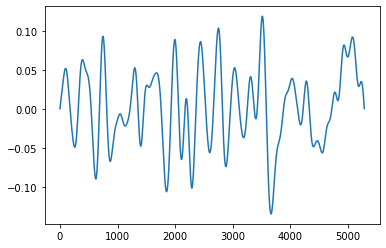

In [0]:
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

fig, ax = plt.subplots()
#ax.plot(gaussian_filter1d(Y_speechtempo, 12))
#ax.plot(gaussian_filter1d(Y_sentiment_interp, 12))
ax.plot(100 * gaussian_filter1d(Y_sentiment_interp, 60, order=1))
#ax.plot(100 * gaussian_filter1d(np.diff(Y_sentiment_interp), 60))
plt.show()

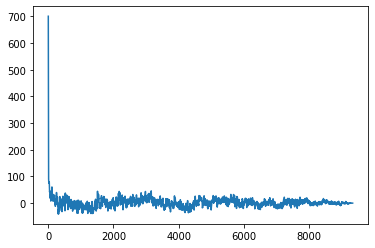

In [0]:
def autocorr(y):
  result = np.correlate(y, y, mode='full')
  return result[result.size // 2:]

fig, ax = plt.subplots()
ax.plot(autocorr(Y_sentiment_interp))
plt.show()

In [0]:
pickle.dump(test_clusters_sentiments, open("test_clusters_sentiments.p", "wb"))

In [0]:
pickle.dump(test_clusters_speechtempos, open("test_clusters_speechtempos.p", "wb"))

In [0]:
test_clusters_speechtempos = pickle.load(open("test_clusters_speechtempos.p", "rb"))

In [0]:
test_clusters_sentiments = pickle.load(open("test_clusters_sentiments.p", "rb"))

curve: mean, std, autocorrelation_lag, linear_trend, polytrend, 
1st diff: mean, std, mean_abs, std_abs, zero_crossings_rate, autocorrelation_lag, sum_abs
2nd diff: mean, std, mean_abs, std_abs, zero_crossings_rate, sum_abs

In [0]:
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skew, kurtosis, hmean, gmean
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import minmax_scale, quantile_transform
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

def mean_std(y):
    return [np.mean(y), np.std(y), np.mean(np.abs(y)), np.std(np.abs(y)), np.sum(np.abs(y))]
def below_mean(y):
  return len([x for x in y if x < np.mean(y)])/len(y)
def linear_trend(x, y):
  slope, intercept = np.polyfit(x, y, 1)
  return slope, intercept
def polyfit(x, y):
  coeff1, coeff2, coeff3 = np.polyfit(x, y, 2)
  return coeff1, coeff2, coeff3
def autocorr(y):
  #y = y - np.mean(y)
  #std = np.std(y)
  result = np.correlate(y, y, mode='full')
  result = result[result.size // 2:]
  return scale(result[60:])
  #peaks, peaks_props = find_peaks(result, distance=1, height=0, threshold=0, prominence=0)
  #i, lag = [(i, peaks[i]) for i in peaks_props["prominences"].argsort()[::-1]][0]
  #height = peaks_props["peak_heights"][i]
  #return 1/lag, 1/(lag/len(y)), height/max(peaks_props["peak_heights"])
def zero_crossings_rate(y):
  positive = np.diff(y) > 0
  n_crossings = len(np.where(np.bitwise_xor(positive[1:], positive[:-1]))[0])
  return n_crossings / len(y)
def mean_crossings_rate(y):
  return zero_crossings_rate(np.array(y) - np.mean(y))
def running_mean(x, N):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / float(N)
def interquartile_range(y):
  median = np.median(y)
  median_above = np.median(y[y > median])
  median_below = np.median(y[y < median])
  return median_above - median_below, median_below, median_above
def outlier_rates(y):
  i_range, median_below, median_above = interquartile_range(y)
  outliers_above = len(y[y > median_above])
  outliers_below = len(y[y < median_below])
  return outliers_above / len(y), outliers_below / len(y)
def quartile_crossings_rates(y):
  i_range, median_below, median_above = interquartile_range(y)
  return zero_crossings_rate(np.array(y) - median_above), zero_crossings_rate(np.array(y) - median_below)
def peak_widths_(y):
  peaks, _ = find_peaks(y)
  results_half = peak_widths(y, peaks, rel_height=0.1)  
  results_full = peak_widths(y, peaks, rel_height=1.0)
  return np.std(results_full[0]), np.median(results_full[0])
def zcr_trend(y):
  result = seasonal_decompose(y, model='additive', freq=30*60)
  return zero_crossings_rate([x for x in result.trend if not np.isnan(x)])
def mcr_trend(y):
  result = seasonal_decompose(y, model='additive', freq=30*60)
  return mean_crossings_rate([x for x in result.trend if not np.isnan(x)])

def extract_curve_features(x_, y_):
  """
  ["mean", "std", "abs_mean", "abs_std", "abs_sum", "below_mean", "above_mean"
  "lin_slope", "lin_intercept", "poly_0", "poly_1", "poly_2", "lag", 
  "rel_lag", "autocorr_height", "d_mean", "d_std", "d_abs_mean", "d_abs_std", 
  "d_abs_sum", "d_zcr", "d_lag", "d_rel_lag", "d_autocorr_height",
  "d2_mean", "d2_std", "d_abs_mean", "d_abs_std", "d_abs_sum", "d2_zcr"]
  """

  diff1 = np.diff(y_)
  diff2 = np.diff(diff1)

  #autocorr_ = autocorr(y_)

  return np.concatenate((np.mean(y_), np.std(y_), np.mean(np.abs(y_)),#below_mean(y_), 
                         np.mean([x for x in y_[int(len(y_)/4):int(3 * (len(y_)/4))] if x != 0]) - np.mean([x for x in y_[:int(len(y_)/2)] if x != 0]),
                         np.mean([x for x in y_[int(len(y_)/2):] if x != 0]) - np.mean([x for x in y_[int(len(y_)/4):int(3 * (len(y_)/4))] if x != 0]),
                         min(y_), max(y_), max(y_) - min(y_),
                         (linear_trend(x_, y_)[0] > 0), polyfit(x_, y_), #autocorr(y_),
                         #binned_entropy(y_, 10), 
                         mean_crossings_rate(y_),
                         mean_crossings_rate(running_mean(y_, 1200)),
                         zero_crossings_rate(y_),
                         zero_crossings_rate(running_mean(y_, 1200)),
                         zcr_trend(y_), mcr_trend(y_),
                         #skew(y_), kurtosis(y_), 
                         #gmean([x for x in y_ if x != 0]),
                         interquartile_range(y_),
                         #peak_widths_(y_), 
                         np.mean(diff1), np.mean(diff2),
                         np.mean(np.abs(diff1)), zero_crossings_rate(diff1), #autocorr(diff1), 
                         np.mean(np.abs(diff2)), zero_crossings_rate(diff2), 
                         mean_crossings_rate(y_) / zero_crossings_rate(diff1),
                         mean_crossings_rate(y_) / zero_crossings_rate(diff2)), axis=None)



In [0]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skew, kurtosis, hmean, gmean
from sklearn.preprocessing import minmax_scale, quantile_transform
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from scipy.signal import find_peaks, argrelextrema, detrend

def linear_trend(x, y):
  slope, intercept = np.polyfit(x, y, 1)
  return slope, intercept
def polyfit(x, y):
  coeff1, coeff2, coeff3 = np.polyfit(x, y, 2)
  return coeff1, coeff2, coeff3
def zero_crossings_rate(y):
  positive = np.diff(y) > 0
  n_crossings = len(np.where(np.bitwise_xor(positive[1:], positive[:-1]))[0])
  return n_crossings / len(y)
def mean_crossings_rate(y):
  return zero_crossings_rate(np.array(y) - np.mean(y))
def interquartile_range(y):
  median = np.median(y)
  median_above = np.median(y[y > median])
  if len(y[y < median]) == 0:
    median_below = 0
  else:
    median_below = np.median(y[y < median])
  return median_above - median_below, median_below, median_above
def zcr_trend(y):
  result = seasonal_decompose(y, model='additive', freq=30*60)
  return zero_crossings_rate([x for x in result.trend if not np.isnan(x)])
def mcr_trend(y):
  result = seasonal_decompose(y, model='additive', freq=30*60)
  return mean_crossings_rate([x for x in result.trend if not np.isnan(x)])

def extract_curve_features(x_, y_, smoothing):

  diff1 = gaussian_filter1d(y_, smoothing, order=1)
  diff1_300 = gaussian_filter1d(y_, 60, order=1)
  diff2 = gaussian_filter1d(y_, smoothing, order=2)
  diff2_300 = gaussian_filter1d(y_, 60, order=2)
  y_300 = gaussian_filter1d(np.array(y_), 60)
  #y_ = gaussian_filter1d(np.array(y_), smoothing)

  """
  return np.concatenate((np.mean(y_), np.std(y_), np.mean(np.abs(y_)),
                         np.mean([x for x in y_[int(len(y_)/4):int(3 * (len(y_)/4))] if x != 0]) - np.mean([x for x in y_[:int(len(y_)/2)] if x != 0]),
                         np.mean([x for x in y_[int(len(y_)/2):] if x != 0]) - np.mean([x for x in y_[int(len(y_)/4):int(3 * (len(y_)/4))] if x != 0]),
                         min(y_), max(y_), max(y_) - min(y_),
                         (linear_trend(x_, y_)[0] > 0), polyfit(x_, y_), #autocorr(y_),
                         #binned_entropy(y_, 10), 
                         mean_crossings_rate(y_),
                         mean_crossings_rate(y_300),
                         zero_crossings_rate(y_),
                         zero_crossings_rate(y_300),
                         mean_crossings_rate(detrend(y_300)),
                         zcr_trend(y_), mcr_trend(y_),
                         #skew(y_), kurtosis(y_), 
                         #gmean([x for x in y_ if x != 0]),
                         interquartile_range(y_),
                         #peak_widths_(y_), 
                         np.mean(diff1), np.mean(diff2), np.std(diff1), np.std(diff2),
                         np.mean(np.abs(diff1)), zero_crossings_rate(diff1), zero_crossings_rate(diff1_300),
                         np.mean(np.abs(diff2)), zero_crossings_rate(diff2), zero_crossings_rate(diff2_300)), axis=None)
    """

  #all_ys = [running_mean(y_, sm_f) for sm_f in [1,2,3,4,5,10,20,60,120,300,600,1200]]
  #all_diff1 = [np.diff(running_mean(y_, sm_f)) for sm_f in [1,2,3,4,5,10,20,60,120,300,600,1200]]
  #all_diff2 = [np.diff(np.diff(running_mean(y_, sm_f))) for sm_f in [1,2,3,4,5,10,20,60,120,300,600,1200]]

  y_ = np.array(running_mean(y_, smoothing_factor))
  all_ys = [y_]
  all_diff1 = [np.diff(y_)]
  all_diff2 = [np.diff(np.diff(y_))]

  return np.concatenate(([np.concatenate([len(y_), np.mean(y_), interquartile_range(y_)[1:], zero_crossings_rate(y_), mean_crossings_rate(y_), min(y_), max(y_)], axis=None) for y_ in all_ys],
                          [[np.mean(np.abs(y_)), np.mean(y_), zero_crossings_rate(y_), min(y_), max(y_)] for y_ in all_diff1], 
                          [[np.mean(np.abs(y_)), np.mean(y_), zero_crossings_rate(y_), min(y_), max(y_)] for y_ in all_diff2]), axis=None)



In [0]:
speechtempo_features['100049']

array([1.50368340e+00, 1.15787293e+00, 1.81111689e+00, 6.33887271e-03,
       6.33887271e-03, 3.67315104e-03, 5.20904729e-02, 7.24689888e-05,
       6.47472151e-01])

In [0]:
positive = np.diff(y_) > 0
print(np.where(np.bitwise_xor(positive[1:], positive[:-1])))

(array([  86,  178,  212,  446,  479,  547,  607,  610,  655,  690,  931,
        939,  946,  976,  994, 1055, 1065, 1071, 1133, 1135, 1156, 1200,
       1339, 1414, 1418, 1428, 1454, 1505, 1527, 1636, 1672, 1676, 1695,
       1819, 1904, 1915, 1969, 1971, 2055, 2064, 2134, 2179, 2283, 2313,
       2373, 2378, 2392, 2393, 2411, 2445, 2451, 2454, 2467, 2482, 2504,
       2505, 2547, 2558, 2590, 2711, 2737, 2748, 2792, 2848, 2878, 2894,
       2959, 3073, 3165, 3180, 3187, 3202, 3231, 3254, 3256, 3276, 3291,
       3353, 3401, 3422, 3517, 3527, 3538, 3571, 3576, 3599, 3607, 3623,
       3657, 3671, 3682, 3711, 3811, 3912, 3952, 3981, 4018, 4089, 4096,
       4168, 4175, 4185, 4187, 4280, 4321, 4324, 4342, 4350, 4356, 4365,
       4389, 4528, 4569, 4574, 4647, 4675, 4775, 4820, 4844, 4868, 4990,
       4994, 5027, 5041, 5058, 5072, 5095, 5192, 5232, 5319, 5340, 5341,
       5346, 5366, 5369, 5407, 5408, 5509, 5567, 5590, 5593, 5725, 5790,
       5820, 6008, 6049, 6181, 6278, 6286, 6299, 6

In [0]:
import numpy as np
autocorr(np.array([x*x for x in [1,2,3,4,5,6,7,8,1,2,3,4,5,6,7,8,]]))

array([1.        , 0.63347431, 0.33471841, 0.1212436 , 0.00660384,
       0.        , 0.1058841 , 0.3235636 , 0.64680567, 0.51020257,
       0.3835918 , 0.27656996, 0.19794217, 0.15532636, 0.15475749,
       0.20029186])

In [0]:
from matplotlib import pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, acovf
import numpy as np
from scipy.signal import find_peaks, argrelextrema, detrend
from scipy.fftpack import dct
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import minmax_scale, quantile_transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale

#def autocorr(y):
#    result = np.correlate(y, y, mode='full')
#    return result[result.size // 2:]

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

"""
column_names = ["mean", "std", "abs_mean", #"abs_std", "abs_sum", "below_mean",
  "slope_rough_1", "slope_rough_2",
  "min", "max", "range",
  "lin_slope_pos", "poly_0", "poly_1", "poly_2", #"lag", 
  #"rel_lag", "autocorr_height", 
  #"binned_entropy",
  "mcr", "mcr_smoothed", "zcr", "zcr_smoothed", "mcr_detrended",
  "zcr_trend", "mcr_trend", 
  #"skew", "kurtosis", 
  #"gmean", 
  #"d_mean", "d_std", 
  "interquartile_range", "median_q1", "median_q3",
  #"peak_width_half", "peak_width_full", 
  "d_mean", "d2_mean", "d_std", "d2_std",
  "d_abs_mean", #"d_abs_std", "d_abs_sum", 
  "d_zcr", "d_zcr_300",  #"d_lag", "d_rel_lag", "d_autocorr_height",
  #"d2_mean", "d2_std", 
  "d2_abs_mean", #"d2_abs_std", "d2_abs_sum", 
  "d2_zcr", "d2_zcr_300"]
"""

factors = [1]

column_names = [(feat) for i in factors for feat in ["len", "mean", "median_q1", "median_q3", "zcr", "mcr", "min", "max"]] 
column_names += [("diff1_" + feat) for i in factors for feat in ["abs_mean", "mean", "zcr", "min", "max"]]
column_names += [("diff2_" + feat) for i in factors for feat in ["abs_mean", "mean", "zcr", "min", "max"]]

speechtempo_features = {}
sentiment_features = {}
autocorrs = {}
autocorrs_detrended = {}
autocorr_peaks = {}
dct_data = {}
dct_data_norm = {}
interp_accuracies = [[], []]
for smoothing_factor in [20]:
  for id_, val in test_clusters_sentiments.items():
    #x_ = [np.mean(val["x"][i:i+20]) for i in range(0, len(val["x"])-19)]
    x_ = val["x"]
    #y_ = [np.mean(val["y"][i:i+20]) for i in range(0, len(val["y"])-19)]
    y_ = val["y"]
    x_ = x_[:len(y_)]
    #y_detrended = detrend(y_)
    sentiment_features[id_] = extract_curve_features(x_, y_, smoothing_factor)
    speechtempo_features[id_] = extract_curve_features(test_clusters_speechtempos[id_]['x'], test_clusters_speechtempos[id_]['y'], smoothing_factor)
    #max_peaks, max_peaks_props = find_peaks(y_, distance=1, height=0, threshold=0, prominence=1)
    #min_peaks, min_peaks_props = find_peaks(-1*np.array(y_)+5, distance=1, height=0, threshold=0, prominence=1)
    #print(min_peaks)
    #minima = argrelextrema(np.array(y_), np.less)
    #fig, ax = plt.subplots()
    #plot_acf(np.array(y_), lags=int(len(np.array(y_))/2), zero=False, alpha=.1)
    #plt.show()
    #plt.plot(np.arange(int(len(y_)/2) + 1), acf(np.array(y_), nlags=int(len(y_)/2), alpha=.1, fft=True)[0])
    #plt.show()
    #plt.plot(x_, autocorr(y_))
    #plt.show()
    #print([min_peaks[i] for i in min_peaks_props["prominences"].argsort()[-10:][::-1]])
    #print(speechtempo_features[id_])
    #coeff = acovf(np.array(y_), nlag=int(len(y_)/2), fft=True, demean=True)
    #maxima, maxima_props = find_peaks(coeff, distance=120, height=0, threshold=0, prominence=0)
    #minima, minima_props = find_peaks(-1*coeff, distance=120, height=0, threshold=0, prominence=0)
    #top_maxima = [maxima[i] for i in sorted(maxima_props["prominences"].argsort()[-4:][::-1])]
    #top_minima = [minima[i] for i in sorted(minima_props["prominences"].argsort()[-4:][::-1])]
    #extrema = np.sort(np.concatenate((top_maxima, top_minima), axis=None))
    #extrema_coeffs = [coeff[i] for i in extrema]
    #autocorr_peaks[id_] = np.concatenate((extrema, extrema_coeffs), axis=None)
    #autocorrs_detrended[id_] = acovf(np.array(y_detrended), nlag=int(len(y_)/2), fft=True, demean=True)
    #autocorrs[id_] = acovf(np.array(y_), nlag=int(len(y_)/2), fft=True, demean=True)
    #dct_data[id_] = dct(y_, norm=None)
    #dct_data_norm[id_] = dct(y_, norm='ortho')
    #ax.plot(np.arange(len(dct_data[id_])), 0.00001*dct_data[id_])
    #ax.plot(np.arange(int(len(y_)/2) + 1), autocorrs[id_])
    #ax.plot(np.arange(int(len(y_)/2) + 1), autocorrs_detrended[id_])
    #plt.show()
  #interp_accuracies[interp_window_size] = []
  sentiment_features_df = pd.DataFrame.from_dict(sentiment_features, orient='index', columns=column_names)
  #sentiment_features_df["title"] = sentiment_features_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
  #sentiment_features_df["class"] = sentiment_features_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0]) 
  features_dict = sentiment_features
  for key in features_dict.keys():
    features_dict[key] = np.append(features_dict[key], speechtempo_features[key])
  features_df = pd.DataFrame.from_dict(features_dict, orient='index', columns=column_names + ["speech_" + x for x in column_names])
  features_df["title"] = sentiment_features_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
  features_df["class"] = sentiment_features_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][-1]) 
  #data = minmax_scale(speechtempo_features_df.iloc[:,:-2])
  #knc = KNeighborsClassifier(n_neighbors=5, p=1)
  #knc.fit(data[::2,:], speechtempo_features_df["class"][::2])
  #y_pred = knc.predict(data[1::2,:])
  #y_true = speechtempo_features_df["class"][1::2]
  #interp_accuracies[interp_window_size].append(accuracy_score(y_true, y_pred))
  #skb = SelectKBest(f_classif, k=5)
  #skb.fit(minmax_scale(speechtempo_features_df.iloc[:,:-2]), speechtempo_features_df["class"])
  #print(interp_window_size, gmean([skb.scores_[i] for i in np.argsort(skb.scores_)[-6:]]))
  #X_new = skb.transform(minmax_scale(speechtempo_features_df.iloc[:,:-2]))
  #data = minmax_scale(X_new[:,:-2])
  #knc = KNeighborsClassifier(n_neighbors=5, p=1)
  #knc.fit(data[::2,:], speechtempo_features_df["class"][::2])
  #interp_accuracies[interp_window_size].append(accuracy_score(y_true, y_pred))
  #interp_accuracies[interp_window_size].append([(speechtempo_features_df.columns[i], skb.pvalues_[i]) for i in np.argsort(skb.scores_)[::-1]][:10])
  #print(interp_window_size, interp_accuracies[interp_window_size])
  #knc = KNeighborsClassifier(n_neighbors=10, p=1)
  #knc.fit(minmax_scale(speechtempo_features_df.iloc[1::2,:-2]), speechtempo_features_df["class"][1::2])
  #y_pred = knc.predict(minmax_scale(speechtempo_features_df.iloc[::2,:-2]))
  #y_true = speechtempo_features_df["class"][::2]
  #fscore_value = np.mean(precision_recall_fscore_support(y_true, y_pred)[2])
  #knc.fit(minmax_scale(speechtempo_features_df.iloc[::2,:-2]), speechtempo_features_df["class"][::2])
  #y_pred = knc.predict(minmax_scale(speechtempo_features_df.iloc[1::2,:-2]))
  #y_true = speechtempo_features_df["class"][1::2]
  #fscore_value = (fscore_value + np.mean(precision_recall_fscore_support(y_true, y_pred)[2])) / 2
  #interp_accuracies[0].append(interp_window_size) 
  #interp_accuracies[1].append(fscore_value)
  knc = KNeighborsClassifier(n_neighbors=10, p=1)
  columns = ["len", "mean", "median_q1", "median_q3", "mcr", "d2_zcr", "d_zcr", 
           "speech_mcr", "speech_mean", "speech_median_q1", "speech_median_q3", "speech_d_zcr", "speech_d2_zcr"]
  print(smoothing_factor, np.mean(cross_val_score(knc, scale(features_df.iloc[:,:-2]), features_df["class"], cv=5)))

20 0.29988095238095236


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
import numpy as np
speechtempo_raw = {}
for film_id, data in test_clusters_speechtempos.items():
  speechtempo_raw[film_id] = np.interp(np.arange(100), data["x"], data["y"])
speechtempo_raw_df = pd.DataFrame.from_dict(speechtempo_raw, orient='index')
speechtempo_raw_df["class"] = speechtempo_raw_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])
knc = KNeighborsClassifier(n_neighbors=10, p=1)
knc.fit(scale(speechtempo_features_df.iloc[30:,:-2].loc[:,["mcr", "d_zcr", "mean", "std"]]), speechtempo_features_df["class"][30:])


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                     weights='uniform')

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, max_depth=20, max_features=len(features_df.columns[:-2]),
                             random_state=0, warm_start=False)
clf.fit(scale(features_df.loc[:,list(features_df.columns[:-2])[::-1]]), features_df["class"])  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=18, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
list(zip(clf.feature_importances_,
list(features_df.columns)))

[(0.03682708730198701, '_mean'),
 (0.049431771912471785, '_median_q1'),
 (0.03276206044423125, '_median_q3'),
 (0.03417848566255102, '_zcr'),
 (0.03225110106739413, '_mcr'),
 (0.032357066067319355, '_diff1_abs_mean'),
 (0.050956813076285, '_diff1_zcr'),
 (0.041520306187312755, '_diff2_abs_mean'),
 (0.03839487333048945, '_diff2_zcr'),
 (0.06387094342590315, 'speech__mean'),
 (0.0467264123503596, 'speech__median_q1'),
 (0.10419532312371728, 'speech__median_q3'),
 (0.05694395151766026, 'speech__zcr'),
 (0.042580030367777515, 'speech__mcr'),
 (0.04177579778675241, 'speech__diff1_abs_mean'),
 (0.10790224376716312, 'speech__diff1_zcr'),
 (0.07800511621372028, 'speech__diff2_abs_mean'),
 (0.10932061639690453, 'speech__diff2_zcr')]

In [0]:
features_df

,len,mean,median_q1,median_q3,zcr,mcr,min,max,diff1_abs_mean,diff1_mean,diff1_zcr,diff1_min,diff1_max,diff2_abs_mean,diff2_mean,diff2_zcr,diff2_min,diff2_max,speech_len,speech_mean,speech_median_q1,speech_median_q3,speech_zcr,speech_mcr,speech_min,speech_max,speech_diff1_abs_mean,speech_diff1_mean,speech_diff1_zcr,speech_diff1_min,speech_diff1_max,speech_diff2_abs_mean,speech_diff2_mean,speech_diff2_zcr,speech_diff2_min,speech_diff2_max,title,class
266543,5816.0,0.048345,-0.008057,0.102748,0.150619,0.150619,-0.388537,0.585900,0.009603,-6.254466e-05,0.292691,-0.056426,0.062390,0.006451,-1.010956e-06,0.449260,-0.069691,0.060315,5816.0,1.967658,1.20000,2.750000,0.426754,0.426754,0.0,5.250000,0.122794,0.000069,0.680653,-0.950000,0.966667,0.183296,-8.190411e-07,0.751290,-1.200000,1.2750,movieId 6377 Finding Nemo (2003) Name: titl...,114709
234215,8228.0,0.013178,-0.092438,0.103213,0.069640,0.069640,-0.583486,0.556477,0.009108,3.265935e-06,0.178680,-0.068720,0.062111,0.003305,1.575285e-06,0.381717,-0.040817,0.041108,8228.0,1.055977,0.00000,1.900000,0.206004,0.206004,0.0,3.800000,0.064332,0.000182,0.427859,-0.800000,0.800000,0.078590,2.431315e-06,0.505957,-1.133333,1.1300,"movieId 6365 Matrix Reloaded, The (2003) Na...",133093
167260,15769.0,-0.005307,-0.103188,0.103349,0.052254,0.052254,-0.547461,0.653290,0.008274,1.584222e-20,0.134069,-0.066329,0.074929,0.002585,4.400897e-22,0.339951,-0.045886,0.040912,15769.0,0.690421,0.10000,1.116667,0.182193,0.182193,0.0,3.650000,0.043636,0.000010,0.432458,-0.900000,1.033333,0.044235,6.342361e-06,0.533202,-1.143750,1.3500,movieId 7153 Lord of the Rings: The Return ...,120737
96754,9767.0,0.003274,-0.095481,0.084631,0.088871,0.088871,-0.656404,0.618211,0.009446,-1.421031e-21,0.232849,-0.060086,0.059833,0.003987,3.020000e-21,0.435842,-0.066858,0.054419,9767.0,1.245475,0.25000,1.983333,0.295587,0.295587,0.0,4.675000,0.085430,0.000015,0.529388,-1.150000,1.116667,0.125434,5.120328e-06,0.618536,-1.400000,1.4000,"movieId 1127 Abyss, The (1989) Name: title,...",78748
97351,5965.0,0.040886,-0.029648,0.131292,0.091031,0.091031,-0.700616,0.739157,0.010799,2.363783e-05,0.207076,-0.069468,0.059341,0.004302,5.605133e-08,0.404830,-0.042160,0.055330,5965.0,1.462904,0.70000,2.224167,0.261023,0.261023,0.0,3.300000,0.067334,0.000101,0.569752,-0.525000,0.475000,0.069372,1.677008e-05,0.660406,-0.700000,0.6750,movieId 1302 Field of Dreams (1989) Name: t...,120338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903624,9826.0,0.024671,-0.088390,0.116608,0.070832,0.070832,-0.676627,0.886413,0.010120,-1.097025e-05,0.196234,-0.059270,0.067100,0.003468,5.761421e-07,0.412561,-0.053655,0.049629,9826.0,1.134350,0.27381,1.810000,0.242520,0.241909,0.0,7.450000,0.067854,0.000196,0.508092,-1.383333,1.158333,0.084012,-3.211280e-06,0.609222,-1.750000,1.4500,movieId 98809 Hobbit: An Unexpected Journey...,120737
120363,5457.0,0.037912,-0.031220,0.101876,0.106102,0.106102,-0.447338,0.778003,0.010386,6.408607e-06,0.236987,-0.051087,0.056544,0.005017,1.952706e-06,0.425481,-0.044451,0.060509,5457.0,1.572828,0.70000,2.350000,0.343046,0.343046,0.0,4.666667,0.105698,0.000321,0.572764,-0.950000,1.100000,0.153023,-9.165903e-06,0.663061,-1.500000,1.3500,movieId 3114 Toy Story 2 (1999) Name: title...,114709
166485,8700.0,0.113923,0.000000,0.238726,0.060460,0.060460,-0.613162,0.822025,0.010150,-2.447863e-05,0.220370,-0.062097,0.073579,0.002934,-6.802258e-08,0.423661,-0.049537,0.035418,8700.0,0.928691,0.00000,1.642857,0.134023,0.134023,0.0,3.712500,0.051281,0.000067,0.402575,-0.487500,0.466667,0.038302,-2.043893e-06,0.488388,-0.670833,0.4875,movieId 3155 Anna and the King (1999) Name:...,120338
109830,8022.0,0.056180,-0.026741,0.158536,0.079531,0.079531,-0.702179,0.664220,0.011787,1.835463e-05,0.177035,-0.069413,0.072911,0.003992,-3.047432e-06,0.411347,-0.050978,0.037269,8022.0,1.454007,0.80000,2.107143,0.257292,0.257292,0.0,3.707143,0.0641

In [0]:
cross_val_score(clf, scale(sentiment_features_df.iloc[:,:-2]),sentiment_features_df["class"], cv=5)

KeyError: ignored

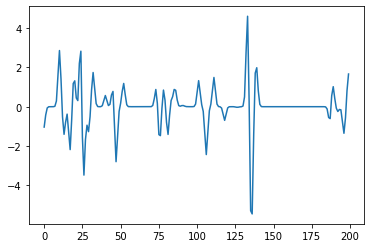

0.0024580090126997134


In [0]:
fig, ax = plt.subplots()
#ax.plot(gaussian_filter1d(y_, 600))
ax.plot(scale(gaussian_filter1d(y_, 1, order=2))[:200])
#ax.plot(scale(np.diff(np.diff(running_mean(y_, 1))))[:200])
#ax.plot(minmax_scale(gaussian_filter1d(y_, 5, order=2)))
plt.show()
print(zero_crossings_rate(gaussian_filter1d(y_, 300, order=2)))

In [0]:
from sklearn.model_selection import cross_val_score
knc = KNeighborsClassifier(n_neighbors=20, p=1)
columns = ["mean", "median_q1", "median_q3", "zcr", "diff1_zcr", "diff2_zcr", "diff1_abs_mean", "diff2_abs_mean",
           "speech_mean", "speech_median_q3", "speech_median_q1", "speech_mcr", "speech_diff1_zcr", "speech_diff2_zcr", "speech_diff1_abs_mean", "speech_diff2_abs_mean"]
#columns = features_df.columns[:-2]
print(min(cross_val_score(knc, scale(features_df.dropna(axis=1).loc[:,columns]), features_df["class"], cv=5)),
      np.mean(cross_val_score(knc, scale(features_df.dropna(axis=1).loc[:,columns]), features_df["class"], cv=5)),
      max(cross_val_score(knc, scale(features_df.dropna(axis=1).loc[:,columns]), features_df["class"], cv=5)))

0.4583333333333333 0.49366666666666664 0.55


In [0]:
features_df.loc[:,:].corr()

,mean,median_q1,median_q3,zcr,mcr,min,max,diff1_abs_mean,diff1_mean,diff1_zcr,diff1_min,diff1_max,diff2_abs_mean,diff2_mean,diff2_zcr,diff2_min,diff2_max,speech_mean,speech_median_q1,speech_median_q3,speech_zcr,speech_mcr,speech_min,speech_max,speech_diff1_abs_mean,speech_diff1_mean,speech_diff1_zcr,speech_diff1_min,speech_diff1_max,speech_diff2_abs_mean,speech_diff2_mean,speech_diff2_zcr,speech_diff2_min,speech_diff2_max,class
mean,1.000000,0.865558,0.754273,0.431314,0.431314,0.370842,0.351261,0.318085,0.127873,0.380122,0.027332,0.034844,0.395748,-0.030439,0.458890,-0.261830,0.170496,0.371140,0.282012,0.403099,0.346941,0.346959,NaN,0.119313,0.376495,0.111426,0.418667,0.017147,-0.031780,0.290828,0.065356,0.419573,-0.051010,0.076067,-0.182642
median_q1,0.865558,1.000000,0.486154,0.607847,0.607847,0.495702,0.016991,0.237819,0.165957,0.475125,0.092692,-0.136214,0.528783,-0.102027,0.422472,-0.367164,0.356745,0.456760,0.301829,0.523325,0.555740,0.555808,NaN,0.208238,0.574977,0.225166,0.543970,-0.159033,0.172829,0.526099,0.110915,0.532547,-0.279632,0.297149,-0.194686
median_q3,0.754273,0.486154,1.000000,0.035308,0.035308,-0.055927,0.462357,0.376362,0.078267,0.099057,-0.112902,0.218120,0.085218,-0.015780,0.418650,0.001159,-0.171971,0.112356,0.196023,0.053096,-0.054881,-0.054848,NaN,-0.138775,-0.023058,-0.043415,0.110340,0.176714,-0.225596,-0.111002,-0.050599,0.139432,0.208754,-0.158029,-0.020471
zcr,0.431314,0.607847,0.035308,1.000000,1.000000,0.405951,-0.107430,0.523883,0.073104,0.655366,-0.205963,0.046640,0.964093,-0.120547,0.514061,-0.565347,0.539215,0.890712,0.732085,0.909618,0.951473,0.951523,NaN,0.506800,0.934729,0.407970,0.901204,-0.192131,0.222102,0.874370,0.203286,0.860954,-0.351184,0.362867,-0.330327
mcr,0.431314,0.607847,0.035308,1.000000,1.000000,0.405951,-0.107430,0.523883,0.073104,0.655366,-0.205963,0.046640,0.964093,-0.120547,0.514061,-0.565347,0.539215,0.890712,0.732085,0.909618,0.951473,0.951523,NaN,0.506800,0.934729,0.407970,0.901204,-0.192131,0.222102,0.874370,0.203286,0.860954,-0.351184,0.362867,-0.330327
min,0.370842,0.495702,-0.055927,0.405951,0.405951,1.000000,-0.233964,-0.147387,0.102516,0.309726,0.368855,-0.326658,0.296192,0.021885,-0.018547,-0.062812,0.088098,0.235555,0.146855,0.273032,0.408682,0.408759,NaN,0.206335,0.387409,0.091956,0.270682,-0.014992,0.079320,0.404331,0.122566,0.235779,-0.150849,0.133949,-0.050504
max,0.351261,0.016991,0.462357,-0.107430,-0.107430,-0.233964,1.000000,0.326373,-0.133852,-0.071645,-0.184061,0.415706,-0.014832,0.136879,0.209975,0.045724,-0.123451,-0.013550,0.059816,-0.052448,-0.136338,-0.136610,NaN,-0.036844,-0.213019,-0.273534,0.040550,0.258340,-0.285312,-0.288387,-0.216773,0.059405,0.245936,-0.306201,0.012813
diff1_abs_mean,0.318085,0.237819,0.376362,0.523883,0.523883,-0.147387,0.326373,1.000000,-0.044975,0.126125,-0.556733,0.601863,0.692082,0.027693,0.643295,-0.400270,0.294156,0.701851,0.747280,0.598756,0.492272,0.492250,NaN,0.210892,0.419199,0.146032,0.727995,0.009994,-0.043234,0.295044,-0.066222,0.763859,0.011532,0.071050,-0.191173
diff1_mean,0.127873,0.165957,0.078267,0.073104,0.073104,0.102516,-0.133852,-0.044975,1.000000,0.219173,0.130689,-0.248356,0.078832,-0.327387,0.015382,0.001268,0.051129,0.053154,-0.054214,0.108092,0.011936,0.012013,NaN,0.054504,0.052438,0.245778,-0.027388,-0.046632,0.093039,0.028415,-0.027520,-0.051426,-0.019462,0.061059,-0.073041
diff1_zcr,0.380122,0.475125,0.099057,0.655366,0.655366,0.309726,-0.071645,0.126125,0.219173,1.000000,-0.007764,-0.039687,0.592891,-0.227409,0.631084,-0.354173,0.284614,0.479761,0.277976,0.562480,0.558893,0.558943,NaN,0.413646,0.647697,0.293371,0.373988,-0.192050,0.232582,0.637438,0.189682,0.302490,-0.268029,0.262754,-0.191988


In [0]:
speechtempo_features_df.corr()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-1e11ac1b01d0>", line 1, in <module>
    speechtempo_features_df.corr()
NameError: name 'speechtempo_features_df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-packages

NameError: ignored

,d2_mean
266543,-1.385844e-08
315983,-1.838744e-08
340377,-8.814690e-09
364569,-8.251911e-09
167260,1.527827e-09
...,...
120363,-1.091362e-08
169547,-7.730700e-09
165854,2.909034e-09
110357,-8.674383e-09


In [0]:
skb = SelectKBest(f_classif, k=4)
skb.fit(scale(features_df.iloc[:,:-2]), features_df["class"])
[(features_df.columns[i], skb.pvalues_[i]) for i in np.argsort(skb.scores_)[-1000:]]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [22] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[('diff2_mean', 0.9337685373017166),
 ('diff1_mean', 0.711206895863072),
 ('speech_diff2_mean', 0.5417449567541359),
 ('speech_max', 0.4393603090722116),
 ('speech_diff1_mean', 0.3233054050550278),
 ('speech_diff1_min', 0.14822008182622376),
 ('diff1_min', 0.12386812300243874),
 ('diff2_zcr', 0.12149775419336621),
 ('speech_diff1_max', 0.10333106434509798),
 ('speech_diff2_max', 0.06647025387349083),
 ('diff1_max', 0.06586534341200931),
 ('speech_diff2_min', 0.0641335046875391),
 ('diff2_min', 0.0630239292324075),
 ('diff2_max', 0.06271283149290453),
 ('max', 0.0246958682457277),
 ('diff1_zcr', 0.01254276559445704),
 ('speech_median_q1', 0.010783972657045797),
 ('min', 0.005790923593371419),
 ('diff1_abs_mean', 0.0036406065233586587),
 ('speech_diff2_zcr', 0.000911963276765292),
 ('median_q1', 0.00034314769343442146),
 ('speech_diff1_zcr', 0.0003234595127606776),
 ('speech_mean', 0.00029443673153634726),
 ('mean', 0.00026394721105588696),
 ('mcr', 0.00022732167665532712),
 ('zcr', 0.00

In [0]:
columns = ["mean", "median_q1", "median_q3", "zcr", "diff2_zcr", "diff1_zcr", "diff1_abs_mean", "diff2_abs_mean",
           "speech_mean", "speech_median_q3", "speech_median_q1", "speech_mcr", "speech_diff2_zcr", "speech_diff1_zcr", "speech_diff1_abs_mean", "speech_diff2_abs_mean"]

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
knc = KNeighborsClassifier(n_neighbors=10, p=1)
labels = sorted(set(features_df["class"]))

#columns = ["mean", "median_q1", "median_q3", "d2_zcr", 
#           "speech_mean", "speech_median_q1", "speech_median_q3", "speech_d2_zcr"]
y_pred = cross_val_predict(knc, scale(features_df.loc[:,columns]), features_df["class"], cv=5)
conf_mat = confusion_matrix(features_df["class"], y_pred, labels=labels)

In [0]:
features_df.columns

Index(['_mean', '_median_q1', '_median_q3', '_zcr', '_mcr', '_diff1_abs_mean',
       '_diff1_zcr', '_diff2_abs_mean', '_diff2_zcr', 'speech__mean',
       'speech__median_q1', 'speech__median_q3', 'speech__zcr', 'speech__mcr',
       'speech__diff1_abs_mean', 'speech__diff1_zcr', 'speech__diff2_abs_mean',
       'speech__diff2_zcr', 'title', 'class'],
      dtype='object')

[[ 4  4  4  5  5]
 [ 2 10  7  3  2]
 [ 0  8 14  0  2]
 [ 1  3  2 14  4]
 [ 2  1  3  5 13]]


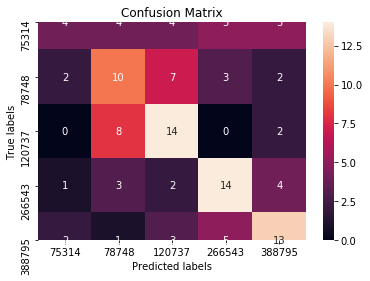

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt     

fig, ax = plt.subplots() 
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
print(conf_mat)

In [0]:
print(np.array([12345,23456222], dtype=np.int32).nbytes)

8


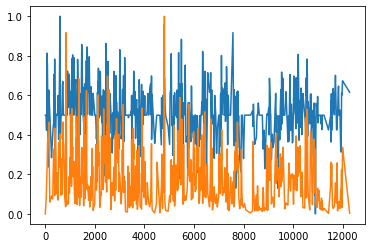

In [0]:
fig, ax = plt.subplots()
ax.plot(test_clusters_sentiments['120737']['x'], minmax_scale(test_clusters_sentiments['120737']['y']))
ax.plot(test_clusters_speechtempos['120737']['x'], minmax_scale(test_clusters_speechtempos['120737']['y']))
plt.show()

In [0]:
np.mean(interp_accuracies[1][:61])

0.18141210513415862

In [0]:
from sklearn.neighbors import KNeighborsClassifier
skb = SelectKBest(f_classif, k=9)
skb.fit(scale(features_df.loc[:,["mean", "mcr", "d2_abs_mean", "d_abs_mean", "median_q1", "median_q3", "speech_mean", "speech_mcr", "speech_median_q3"]]), features_df["class"])
X_new = skb.transform(scale(features_df.loc[:,["mean", "mcr", "d2_abs_mean", "d_abs_mean", "median_q1", "median_q3", "speech_mean", "speech_mcr", "speech_median_q3"]]))
data = X_new
knc = KNeighborsClassifier(n_neighbors=20, p=1)
knc.fit(data[::2,:], features_df["class"][::2])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

In [0]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import scale
from collections import Counter
y_pred = knc.predict(data[1::2,:])
y_true = features_df["class"][1::2]
print(set(y_true))
print(precision_recall_fscore_support(y_true, y_pred))
print(Counter(y_pred))
print(Counter(y_true))
print(cross_val_score(knc, scale(features_df.loc[:,["mean", "mcr", "median_q1", "median_q3", "speech_mean", "speech_mcr", "speech_median_q1", "speech_median_q3"]]), features_df["class"]))

{120737, 85794, 133093, 386117, 56869, 287467, 166924, 266543, 120338, 1193138, 168629, 114709, 780504, 468569, 78748, 120382}
(array([0.        , 0.2       , 0.        , 0.33333333, 0.0952381 ,
       0.        , 0.27272727, 0.2       , 0.23076923, 0.33333333,
       0.        , 0.07692308, 0.        , 0.1       , 0.        ,
       0.33333333]), array([0.        , 0.23076923, 0.        , 0.27272727, 0.28571429,
       0.        , 0.3       , 0.22222222, 0.33333333, 0.11111111,
       0.        , 0.125     , 0.        , 0.16666667, 0.        ,
       0.11111111]), array([0.        , 0.21428571, 0.        , 0.3       , 0.14285714,
       0.        , 0.28571429, 0.21052632, 0.27272727, 0.16666667,
       0.        , 0.0952381 , 0.        , 0.125     , 0.        ,
       0.16666667]), array([ 8, 13,  8, 11,  7,  8, 10,  9,  9,  9,  2,  8,  8,  6,  9,  9]))
Counter({120338: 21, 78748: 15, 166924: 13, 85794: 13, 287467: 13, 120737: 11, 468569: 10, 133093: 10, 114709: 9, 120382: 7, 386117: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: ignored

In [0]:
#speechtempo_features_df["class"] = speechtempo_features_df["class"].astype('category').cat.codes
speechtempo_features_df["class"]

266543     2
315983     6
329575     3
234215     5
364569     6
290334     7
314979     1
315733     6
276919     6
159365     3
242653     5
96754      1
96895      7
97351      3
96794      3
114709     2
114746     5
112573     3
113568     5
114369     0
114887     3
112384     3
3659388    1
1392190    5
5069564    4
4226388    6
2096673    2
3170832    4
52311      0
52357      0
          ..
54167      0
54215      0
1990314    4
2313197    7
2106476    6
1772341    2
1345836    7
1853728    7
1446714    1
1276104    5
1649419    3
2024519    6
1433811    4
2053425    6
133093     1
175880     6
120363     2
169547     4
246645     4
123209     3
120855     2
129167     2
166485     3
137523     4
110391     3
110357     2
110631     0
105946     1
109830     3
110322     3
Name: class, Length: 318, dtype: int8

In [0]:
import pandas as pd
dct_data_df = pd.DataFrame.from_dict(dct_data, orient='index')
dct_data_df["title"] = dct_data_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
dct_data_df["class"] = dct_data_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])

In [0]:
import pandas as pd
dct_data_norm_df = pd.DataFrame.from_dict(dct_data_norm, orient='index')
dct_data_norm_df["title"] = dct_data_norm_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
dct_data_norm_df["class"] = dct_data_norm_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])

In [0]:
import pandas as pd
autocorrs_df = pd.DataFrame.from_dict(autocorrs_detrended, orient='index')
autocorrs_df["title"] = autocorrs_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
autocorrs_df["class"] = autocorrs_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])

In [0]:
import pandas as pd
autocorr_peaks_df = pd.DataFrame.from_dict(autocorr_peaks, orient='index')
autocorr_peaks_df["title"] = autocorr_peaks_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
autocorr_peaks_df["class"] = autocorr_peaks_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])

In [0]:
column_names = ["mean", "std", "abs_mean", "abs_std", "abs_sum", "below_mean",
  #"lin_slope", "lin_intercept", "poly_0", "poly_1", "poly_2", "lag", 
  #"rel_lag", "autocorr_height", 
  #"binned_entropy",
  "d_mean", "d_std", "d_abs_mean", "d_abs_std", 
  "d_abs_sum", "d_zcr", #"d_lag", "d_rel_lag", "d_autocorr_height",
  "d2_mean", "d2_std", "d2_abs_mean", "d2_abs_std", "d2_abs_sum", "d2_zcr",
  "mean_1", "mean_2", "mean_3"]
speechtempo_features_df = pd.DataFrame.from_dict(speechtempo_features, orient='index', columns=column_names)

In [0]:
speechtempo_features_df["title"] = speechtempo_features_df.index.map(lambda x: movies_movielens[movies_movielens.imdbId == int(x)].title)
speechtempo_features_df["class"] = speechtempo_features_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])

In [0]:
speechtempo_features_df

NameError: ignored

In [0]:
speechtempo_features_df["class"] = speechtempo_features_df.index.map(lambda x: [key for key, val in test_clusters.items() if int(x) in val][0])

In [0]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import minmax_scale
X_new = SelectKBest(f_classif, k=5).fit(scale(features_df.iloc[:,:-2]), features_df["class"])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [34] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [0]:
[(features_df.columns[i], X_new.pvalues_[i]) for i in np.argsort(X_new.scores_)[::-1]]

[('speech_min', nan),
 ('mcr', 6.341526243324569e-30),
 ('zcr', 6.68998431304232e-30),
 ('speech_mcr', 2.507408640027554e-29),
 ('speech_zcr', 2.507408640027554e-29),
 ('d2_abs_mean', 2.600352570278981e-29),
 ('speech_mcr_trend', 4.339598915481317e-29),
 ('speech_zcr_trend', 4.339598915481317e-29),
 ('speech_mcr/d2_zcr', 5.162796213817538e-29),
 ('speech_mcr/d_zcr', 5.89156451659221e-29),
 ('speech_zcr_smoothed_nozero', 5.215078732289852e-28),
 ('speech_zcr_smoothed', 5.227632407373912e-28),
 ('d_abs_mean', 2.7671011931500927e-27),
 ('zcr_smoothed_nozero', 1.2074585327996416e-26),
 ('mcr/d2_zcr', 1.6579474903206547e-26),
 ('speech_d_abs_mean', 2.806015822862035e-26),
 ('zcr_smoothed', 4.189127180342999e-26),
 ('speech_abs_mean', 4.66856277276952e-26),
 ('speech_mean', 4.66856277276952e-26),
 ('mcr/d_zcr', 5.763935351056125e-26),
 ('speech_d_zcr', 1.0908605245760993e-25),
 ('speech_median_q3', 1.5659994731819485e-24),
 ('speech_d2_zcr', 8.202313973163313e-24),
 ('speech_median_q1', 9.16

[('d_autocorr_height', 6.150412671631003),
 ('lag', 4.497636673111264),
 ('mean', 3.215773839043892),
 ('abs_mean', 3.215773839043892),
 ('d_abs_mean', 2.6797721034543605),
 ('d_rel_lag', 2.607880003932183),
 ('d_mean', 2.5372499030160767),
 ('d_lag', 2.457638919477689),
 ('d_abs_mean', 2.1891235419799924),...


 [('mean', 3.216460211335276),
 ('abs_mean', 3.216460211335276),
 ('d2_zcr', 2.95843882920257),
 ('d2_abs_mean', 2.584474194245639),
 ('d_zcr', 2.3259033752405514),
 ('d_rel_lag', 2.2477728894072575),
 ('d_abs_mean', 1.9091340664833287),
 ('d_lag', 1.8674953264050491),
 ('below_mean', 1.7241042597363274),
 ('lag', 1.718858900817939),
 ('above_mean', 1.5968532721746302),

 [('d2_zcr', 7.556017381125978),
 ('d_zcr', 5.910325517888287),
 ('d2_abs_mean', 5.215429956897009),
 ('abs_mean', 5.194290023686975),
 ('mean', 5.194290023686975),
 ('above_mean', 4.316167130360235),
 ('below_mean', 4.316167130360123),
 ('d_abs_mean', 4.141162272930658),

In [0]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import minmax_scale
autocorrs_df = autocorrs_df.dropna(axis=1)
X_new = SelectKBest(chi2, k=5).fit(minmax_scale(autocorrs_df.iloc[:,:-2]), autocorrs_df["class"])

In [0]:
[(autocorrs_df.columns[i], X_new.scores_[i]) for i in np.argsort(X_new.scores_)[::-1]]

[(94, 2.8291663473762054),
 (95, 2.810166742229463),
 (41, 2.7045463651992003),
 (81, 2.6947290450821333),
 (82, 2.6783809907838108),
 (96, 2.6645948402985926),
 (40, 2.6572086662778585),
 (42, 2.6530058787344126),
 (80, 2.651233582405777),
 (83, 2.639305213531662),
 (93, 2.6347719713848177),
 (84, 2.5914528877218697),
 (39, 2.562383740128277),
 (43, 2.528265545726958),
 (79, 2.519126196041585),
 (85, 2.5138839047318706),
 (97, 2.5125443748361342),
 (92, 2.478420398863655),
 (38, 2.4656364411674385),
 (86, 2.396144837186779),
 (37, 2.3828915435239044),
 (98, 2.3808472035671264),
 (44, 2.3760458979294548),
 (91, 2.3651721501691396),
 (78, 2.346088283411491),
 (87, 2.313395563392652),
 (90, 2.2981957540459343),
 (36, 2.292750007281629),
 (88, 2.2824697411531627),
 (89, 2.2771287941860723),
 (99, 2.257675655991604),
 (45, 2.2551285540608808),
 (35, 2.241523354484972),
 (34, 2.2171742696154846),
 (33, 2.206288350446263),
 (32, 2.200965830170177),
 (46, 2.1968326026234664),
 (31, 2.19654111

In [0]:
from sklearn.linear_model import Perceptron
clf = Perceptron()
clf.fit(scale(features_df.iloc[::2,:-2]), features_df["class"][::2]) 
from sklearn.metrics import accuracy_score
y_pred = clf.predict(scale(features_df.iloc[1::2,:-2]))
y_true = features_df["class"][1::2]
accuracy_score(y_true, y_pred)

0.28823529411764703

In [0]:
col = autocorr_peaks_df.loc[:,[0,1,2,3,4,5,6,7]]
autocorr_peaks_df["median_lag"] = col.mean(axis=1)
col = autocorr_peaks_df.loc[:,[8,9,10,11,12,13]]
autocorr_peaks_df["median_height"] = col.mean(axis=1)

In [0]:
autocorr_peaks_df.dropna(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,title,class,median_lag,median_height
266543,534.0,659.0,956.0,1041.0,1158.0,1526.0,1615.0,2468.0,-0.077987,0.074257,0.103033,-0.025957,0.114048,-0.063638,movieId 6377 Finding Nemo (2003) Name: titl...,114709,1244.625,0.020626
315983,250.0,464.0,843.0,1337.0,1900.0,1983.0,3083.0,3262.0,-0.040698,0.068670,-0.040583,0.070359,-0.031483,0.055274,movieId 7158 House of Sand and Fog (2003) N...,168629,1640.250,0.013590
234215,389.0,874.0,1153.0,1742.0,2104.0,2721.0,3187.0,3465.0,-0.067671,0.041199,-0.061500,0.052482,-0.063049,0.040751,"movieId 6365 Matrix Reloaded, The (2003) Na...",133093,1954.375,-0.009631
314979,626.0,964.0,1234.0,1383.0,1576.0,2206.0,2963.0,4621.0,-0.054483,0.067640,-0.048942,0.041665,-0.053375,0.054655,movieId 27611 Battlestar Galactica (2003) N...,133093,1946.625,0.001193
315733,67.0,298.0,955.0,1665.0,1784.0,2541.0,2624.0,3068.0,-0.047553,0.056909,-0.045461,0.038777,-0.041989,0.058724,"movieId 6953 21 Grams (2003) Name: title, d...",168629,1625.250,0.003234
276919,225.0,1082.0,1328.0,2282.0,2465.0,2707.0,3456.0,3842.0,-0.055486,0.058735,-0.089579,0.044955,-0.074344,0.048776,"movieId 7371 Dogville (2003) Name: title, d...",168629,2173.375,-0.011157
96754,685.0,1012.0,1508.0,2136.0,2698.0,3120.0,3853.0,4101.0,-0.049243,0.071123,-0.077217,0.061289,-0.038604,0.065726,"movieId 1127 Abyss, The (1989) Name: title,...",78748,2389.125,0.005512
96895,540.0,855.0,1301.0,1669.0,1993.0,2378.0,2529.0,2722.0,0.048631,-0.039191,0.020299,-0.033419,0.034705,-0.029836,"movieId 592 Batman (1989) Name: title, dtyp...",468569,1748.375,0.000198
97351,771.0,874.0,1245.0,1471.0,1642.0,2000.0,2225.0,2411.0,-0.052146,0.035499,-0.081324,0.026471,-0.054510,0.050393,movieId 1302 Field of Dreams (1989) Name: t...,120338,1579.875,-0.012603
96794,201.0,334.0,463.0,738.0,1214.0,1793.0,2262.0,2412.0,-0.058391,0.028540,-0.067830,0.044927,-0.040677,0.040228,"movieId 4564 Always (1989) Name: title, dty...",120338,1177.125,-0.008867


In [0]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import minmax_scale
autocorr_peaks_df = autocorr_peaks_df.dropna(axis=1)
X_new = SelectKBest(f_classif, k=5).fit(minmax_scale(autocorr_peaks_df.loc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,"median_lag","median_height"]]), autocorr_peaks_df["class"])

In [0]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import minmax_scale
X_new = SelectKBest(f_classif, k=5).fit(minmax_scale(speechtempo_features_df.iloc[:,:-2]), dct_data_df["class"])

NameError: ignored

In [0]:
np.concatenate([dct_data_df.iloc[:,:-2].dropna(axis=1), speechtempo_features_df.iloc[:,:-2]], axis=1).shape

(318, 2432)

In [0]:
[(i, X_new.scores_[i]) for i in np.argsort(X_new.scores_)[::-1]]

[(2431, 10.273552598719975),
 (2403, 7.128773377686922),
 (2405, 7.128773377686922),
 (2422, 6.962907795294821),
 (2408, 6.556378313417184),
 (2428, 5.881484370321367),
 (2407, 5.618592608176053),
 (0, 5.61859260817598),
 (2410, 5.549792945332734),
 (2421, 5.265242001987173),
 (525, 4.8469240374639115),
 (2419, 4.839246175789794),
 (2417, 4.629234127110027),
 (748, 4.6079913299911235),
 (524, 4.494604945153383),
 (2413, 4.438932697712983),
 (692, 4.322214479153209),
 (8, 3.9139759697686944),
 (2414, 3.521881167291003),
 (2430, 3.4931605576271463),
 (641, 3.413368184468512),
 (949, 3.388103385897506),
 (21, 3.347438730793409),
 (176, 3.2749155426240395),
 (461, 3.2175481635486944),
 (1289, 3.112667998471829),
 (410, 3.078848239865872),
 (852, 3.033062352846007),
 (1750, 2.9513458125539485),
 (1172, 2.838389687601188),
 (2406, 2.836066737710065),
 (2404, 2.836066737710065),
 (348, 2.821753924205765),
 (1671, 2.8185514998358148),
 (130, 2.745949566605289),
 (360, 2.7089642517187227),
 (10

In [0]:
np.array(features_df["speech_mcr"]) / np.array(features_df["zcr"])

array([0.71118915, 0.47169338, 0.51237472, 0.49464068, 0.54497881,
       0.53441097, 0.5524197 , 0.4948648 , 0.47170428, 0.48892454,
       0.50796415, 0.58371799, 0.45702948, 0.52194687, 0.54815722,
       0.58646367, 0.59294318, 0.49630261, 0.46751624, 0.46222102,
       0.51978306, 0.55177272, 0.52737604, 0.64629275, 0.51501012,
       0.53568742, 0.57131792, 0.53680746, 0.57305492, 0.50578032,
       0.57159548, 0.45874221, 0.50552461, 0.54576389, 0.53492804,
       0.5266485 , 0.49666048, 0.50486701, 0.49313843, 0.50140562,
       0.45935559, 0.6137454 , 0.48018613, 0.56965868, 0.50350016,
       0.52384351, 0.59144881, 0.48247705, 0.52771173, 0.54834864,
       0.53384204, 0.59309738, 0.52095179, 0.5212352 , 0.63629783,
       0.51775751, 0.4861373 , 0.49260419, 0.52042197, 0.51829093,
       0.47771128, 0.48334254, 0.5127076 , 0.45296125, 0.55777231,
       0.50501536, 0.57544528, 0.54523892, 0.52091725, 0.38714404,
       0.53819186, 0.52494265, 0.53540965, 0.48460345, 0.53071

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
columns = "speech_mcr", "speech_mean", "speech_median_q1", "speech_median_q3", "mean", "median_q1", "median_q3", "d2_abs_mean", "d_abs_mean", "zcr"
for n in range(24,25):
  data = SelectKBest(f_classif, k=24).fit_transform(scale(features_df.iloc[:,:-3]), features_df["class"])
  #data = minmax_scale(pd.DataFrame([val["y"] for key, val in test_clusters_speechtempos.items()]).dropna(axis=1))
  knc = KNeighborsClassifier(n_neighbors=10, p=1)
  gnb = GaussianNB()
  svc = SVC(kernel="linear", C=0.025)
  from sklearn.neural_network import MLPClassifier
  clf = MLPClassifier(max_iter=100000, hidden_layer_sizes=(50, 20), n_iter_no_change=10000)
  #clf.fit(data[::2,:], features_df["class"][::2])
  knc.fit(data[::2,:], features_df["class"][::2])
  #gnb.fit(data[::2,:], features_df["class"][::2])
  #svc.fit(data[::2,:], features_df["class"][::2])
  from sklearn.metrics import accuracy_score
  from sklearn.preprocessing import scale
  #y_pred = knc.predict(data[1::2,:])
  #y_true = features_df["class"][1::2]
  #print(precision_recall_fscore_support(y_true, y_pred)[2])
  """
  y_pred = gnb.predict(data[1::2,:])
  y_true = features_df["class"][1::2]
  print(precision_recall_fscore_support(y_true, y_pred)[2])
  y_pred = clf.predict(data[1::2,:])
  y_true = features_df["class"][1::2]
  print(precision_recall_fscore_support(y_true, y_pred)[2])
  y_pred = svc.predict(data[1::2,:])
  y_true = features_df["class"][1::2]
  print(precision_recall_fscore_support(y_true, y_pred)[2])
  """
  print(n, np.mean(cross_val_score(clf, data, features_df["class"], cv=5)))
  #print(n, sorted(set(features_df["class"])))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [34] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


24 0.2643074058588038


In [0]:
fs = [0] * len(features_df.columns[:-3])
for film in (scale(features_df.iloc[:,:-3]) > 3):
  for i, f in enumerate(film):
    if f == True:
      fs[i] += 1

In [0]:
for i in np.argsort(fs)[::-1]:
  print(fs[i], features_df.columns[i])

7 speech_median_q1
6 speech_abs_mean
6 speech_mean
6 poly_0
5 speech_d2_abs_mean
5 speech_d_mean
4 interquartile_range
4 d2_mean
4 d2_abs_mean
3 speech_mcr/d2_zcr
3 poly_1
3 speech_mcr/d_zcr
3 d_zcr
3 speech_median_q3
3 speech_d2_mean
3 speech_d_abs_mean
3 speech_slope_rough_1
2 speech_slope_rough_2
2 speech_std
2 d_abs_mean
2 poly_2
2 speech_max
2 speech_range
2 median_q3
2 speech_poly_2
2 abs_mean
2 std
1 mcr
1 zcr
1 range
1 max
1 slope_rough_2
1 median_q1
1 mean
1 d2_zcr
1 speech_poly_0
1 speech_poly_1
1 speech_mcr
1 speech_zcr
1 speech_interquartile_range
1 speech_d_zcr
0 d_mean
0 mcr/d_zcr
0 speech_min
0 speech_lin_slope_pos
0 lin_slope_pos
0 min
0 slope_rough_1
0 speech_d2_zcr
0 mcr/d2_zcr


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
y_pred = knc.predict(data[1::2,:])
y_true = features_df["class"][1::2]
print(precision_recall_fscore_support(y_true, y_pred)[2])
"""
y_pred = gnb.predict(data[1::2,:])
y_true = features_df["class"][1::2]
print(precision_recall_fscore_support(y_true, y_pred)[2])
y_pred = clf.predict(data[1::2,:])
y_true = features_df["class"][1::2]
print(precision_recall_fscore_support(y_true, y_pred)[2])
y_pred = svc.predict(data[1::2,:])
y_true = features_df["class"][1::2]
print(precision_recall_fscore_support(y_true, y_pred)[2])
"""
print(cross_val_score(knc, data, features_df["class"]))
print(sorted(set(features_df["class"])))


[0.24561404 0.42105263 0.33333333 0.39285714 0.27272727 0.
 0.22857143 0.48484848]
[0.35185185 0.24299065 0.30097087]
[56869, 78748, 114709, 120338, 120382, 133093, 168629, 468569]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(features_df["class"][1::2], knc.predict(data[1::2,:]), labels=sorted(set(features_df["class"])))

NameError: ignored

In [0]:
minmax_scaled_df = speechtempo_features_df
for column in minmax_scaled_df.columns[:-2]:
  minmax_scaled_df[column] = minmax_scale(minmax_scaled_df[column])
for feature_name in minmax_scaled_df.iloc[:,:-2].columns:
  stds = []
  for class_id in set(minmax_scaled_df["class"]):
    stds.append(np.mean(minmax_scaled_df[minmax_scaled_df["class"] == class_id][feature_name]))
  print(feature_name, class_id, np.mean(stds))

mean 120382 0.3162796188926817
mcr 120382 0.4716085685960743
gmean 120382 0.2676249759863891
interquartile_range 120382 0.39322115583112316
autocorr_mean 120382 0.35057911456956115
autocorr_gmean 120382 0.3581279524511536
d_abs_mean 120382 0.3644445691543693
d_zcr 120382 0.3897780982452476
d2_abs_mean 120382 0.2207205850427067
d2_zcr 120382 0.4951549693575453
mcr/d_zcr 120382 0.298922566082521
mcr/d2_zcr 120382 0.39803575761674964


In [0]:
from sklearn.cluster import KMeans
import numpy as np
X = speechtempo_features_df.loc[:,list(speechtempo_features_df.columns[:-2])]
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans.labels_

#kmeans.cluster_centers_
#kmeans.predict(speechtempo_features_df.iloc[])

array([7, 2, 5, 2, 7, 2, 3, 5, 7, 5, 2, 5, 2, 3, 2, 3, 3, 6, 3, 5, 5, 7,
       0, 6, 1, 6, 3, 5, 3, 4, 0, 6, 6, 5, 6, 6, 1, 6, 5, 5, 5, 2, 3, 0,
       2, 2, 5, 4, 3, 0, 3, 0, 2, 3, 7, 1, 3, 7, 0, 4, 5, 7, 6, 2, 3, 5,
       6, 3, 0, 6, 2, 7, 2, 4, 3, 0, 6, 6, 6, 2, 2, 2, 2, 5, 5, 7, 2, 6,
       2, 5, 2, 3, 5, 5, 6, 5, 2, 7, 3, 5, 3, 2, 2, 2, 2, 3, 5, 0, 2, 3,
       3, 0, 5, 3, 6, 2, 2, 0, 3, 5, 3, 0, 2, 2, 0, 0, 5, 0, 7, 6, 0, 4,
       3, 6, 4, 3, 2, 1, 2, 5, 2, 3, 5, 5, 2, 3, 2, 3, 2, 5, 0, 2, 4, 3,
       2, 6, 2, 6, 5, 7, 0, 0, 6, 2, 2, 5, 0, 0, 2, 6, 0, 3, 1, 7, 5, 0,
       3, 0, 4, 6, 3, 6, 5, 6, 2, 6, 6, 5, 6, 2, 5, 2, 0, 0, 5, 5, 1, 6,
       3, 0, 3, 0, 6, 5, 0, 5, 2, 0, 3, 7, 2, 2, 5, 5, 0, 3, 5, 0, 2, 2,
       2, 2, 0, 6, 0, 3, 2, 0, 3, 5, 2, 5, 7, 5, 2, 5, 5, 5, 6, 0, 7, 3,
       3, 2, 5, 0, 2, 0, 6, 5, 0, 3, 3, 2, 3, 2, 0, 6, 6, 2, 2, 2, 6, 3,
       3, 2, 3, 5, 3, 5, 3, 2, 2, 0, 2, 6, 5, 3, 2, 0, 3, 6, 7, 5, 5, 6,
       6, 0, 5, 2, 3, 5, 2, 3, 0, 0, 2, 2, 6, 6, 0,

In [0]:
speechtempo_features_df["class"]

266543     114709
315983     168629
329575     120338
234215     133093
364569     168629
290334     468569
314979      78748
315733     168629
276919     168629
159365     120338
242653     133093
96754       78748
96895      468569
97351      120338
96794      120338
114709     114709
114746     133093
112573     120338
113568     133093
114369      56869
114887     120338
112384     120338
3659388     78748
1392190    133093
5069564    120382
4226388    168629
2096673    114709
3170832    120382
52311       56869
52357       56869
            ...  
54167       56869
54215       56869
1990314    120382
2313197    468569
2106476    168629
1772341    114709
1345836    468569
1853728    468569
1446714     78748
1276104    133093
1649419    120338
2024519    168629
1433811    120382
2053425    168629
133093      78748
175880     168629
120363     114709
169547     120382
246645     120382
123209     120338
120855     114709
129167     114709
166485     120338
137523     120382
110391    

In [0]:
list(speechtempo_features_df.columns[:-2]) + ["class"]

['mean',
 'mcr',
 'gmean',
 'autocorr_mean',
 'autocorr_gmean',
 'd_abs_mean',
 'd_zcr',
 'd2_abs_mean',
 'd2_zcr',
 'mcr/d_zcr',
 'mcr/d2_zcr',
 'class']

In [0]:
clf.coefs_[0][0]

array([ 1.28503407e+000, -1.20554484e+000, -8.83456647e-001,
       -1.34725970e+000, -2.02043454e-001, -3.42981924e-002,
       -1.59374138e+000,  1.92930833e+000, -1.05758137e+000,
       -2.59572480e-111,  2.34598949e+000, -1.17833522e+000,
        6.17419003e-002,  2.04625884e+000,  1.10915877e+000,
        1.97845268e+000,  9.34461051e-001, -1.92191534e+000,
       -1.29985378e-001, -1.61202883e+000,  1.68478883e+000,
        2.31244317e+000,  3.20370894e-132,  4.21907256e-001,
        3.95379351e-001,  1.42485693e+000,  1.70949371e-001,
        2.30558161e+000, -7.98625793e-091])

In [0]:
for i, (id, movie) in enumerate(speechtempo_features_df.iterrows()):
  print(movie.title)
  print(clf.predict([minmax_scale(data[:,:])[i]]))
  print(movie["class"])

movieId
6377    Finding Nemo (2003)
Name: title, dtype: object
[114709]
114709
movieId
27611    Battlestar Galactica (2003)
Name: title, dtype: object
[120382]
78748
movieId
1127    Abyss, The (1989)
Name: title, dtype: object
[78748]
78748
movieId
1    Toy Story (1995)
Name: title, dtype: object
[114709]
114709
movieId
47    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object
[56869]
56869
movieId
134130    The Martian (2015)
Name: title, dtype: object
[78748]
78748
movieId
148667    John Mulaney: The Comeback Kid (2015)
Name: title, dtype: object
[120382]
120382
movieId
134853    Inside Out (2015)
Name: title, dtype: object
[114709]
114709
movieId
140174    Room (2015)
Name: title, dtype: object
[120382]
120382
movieId
1248    Touch of Evil (1958)
Name: title, dtype: object
[120382]
56869
movieId
903    Vertigo (1958)
Name: title, dtype: object
[56869]
56869
movieId
3034    Robin Hood (1973)
Name: title, dtype: object
[120382]
114709
movieId
541    Blade Runner (1982)
Name: title,

In [0]:
from sklearn.linear_model import Perceptron
clf = Perceptron()
clf.fit(minmax_scale(autocorrs_df.iloc[:,:-2]), autocorrs_df["class"]) 
from sklearn.metrics import accuracy_score
y_pred = clf.predict(minmax_scale(autocorrs_df.iloc[:,:-2]))
y_true = autocorrs_df["class"]
accuracy_score(y_true, y_pred, normalize=False)

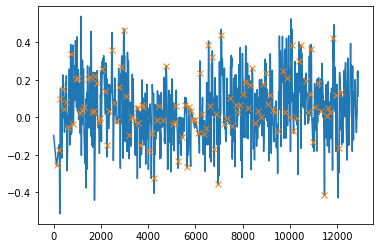

In [0]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

from scipy.signal import find_peaks

autocorr = autocorr(y_)

peaks, peaks_props = find_peaks(autocorr, distance=60, height=0, threshold=0, prominence=0)

fig, ax = plt.subplots()
ax.plot(y_)
plt.plot(peaks, y_[peaks], "x")
plt.show()

In [0]:
period = [peaks[i] for i in peaks_props["prominences"].argsort()[-10:][::-1] if peaks[i] < len(y_)/3][0]

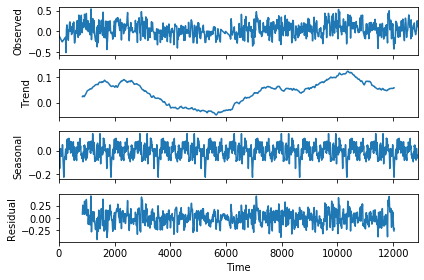

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
#series = interp1d(X, Y, kind="linear")(x_interp)
result = seasonal_decompose(y_, model='additive', freq=period)
result.plot()
pyplot.show()

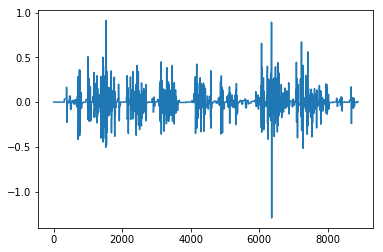

In [0]:
from statsmodels.tsa.tsatools import detrend
fig, ax = plt.subplots()
ax.plot(x_interp, np.diff(interp1d(X, Y, kind="linear")(x_interp), prepend=0, n=1))
plt.show()

In [0]:
positive = np.diff(interp1d(X, Y, kind="linear")(x_interp)) > 0
len(np.where(np.bitwise_xor(positive[1:], positive[:-1]))[0])

442

In [0]:
Y_interp = interp1d(X, Y, kind="linear")(x_interp)
hann = np.hanning(len(Y_interp))
Y_fft = np.fft.fft(hann*Y_interp)

In [0]:
N = int(len(Y_fft)/2+1)
fa = 1.0/(60.0) # every 15 minutes
print('fa=%.4fHz (Frequency)' % fa)

fa=0.0167Hz (Frequency)


In [0]:
X_fft = np.linspace(0, fa/2, N, endpoint=True)

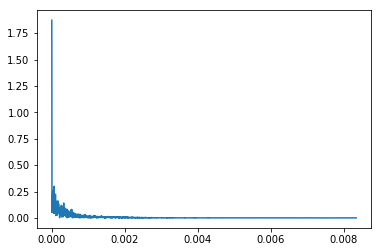

In [0]:
fig, ax = plt.subplots()
ax.plot(X_fft, 2.0*np.abs(Y_fft[:N])/N)
peaks, peaks_props = find_peaks(2.0*np.abs(Y_fft[:N])/N, distance=60, height=0, threshold=0, prominence=0)
#plt.plot(peaks, X_fft[peaks], "x")
plt.show()

In [0]:
X_fft[peaks]


array([6.68002672e-05, 3.25651303e-04, 5.45535515e-04, 7.15319528e-04,
       9.12936985e-04, 1.15508795e-03, 1.36383879e-03, 1.53918949e-03,
       1.81195725e-03, 2.05132487e-03, 2.22389223e-03, 2.47995992e-03,
       2.69149410e-03, 2.99487865e-03, 3.23146293e-03, 3.57103095e-03,
       3.75751503e-03, 3.92451570e-03, 4.16945001e-03, 4.45056780e-03,
       4.66766867e-03, 4.90703629e-03, 5.12413716e-03, 5.35515475e-03,
       5.54998887e-03, 5.72255622e-03, 5.93965709e-03, 6.12614117e-03,
       6.29870853e-03, 6.47405923e-03, 6.72456023e-03, 6.96114451e-03,
       7.18381207e-03, 7.42317969e-03, 7.59574705e-03, 7.76274772e-03,
       7.93531507e-03, 8.15241594e-03, 8.31941661e-03])

In [0]:
peaks, peaks_props = find_peaks(2.0*np.abs(Y_fft[:N])/N, distance=60, height=0, threshold=0, prominence=0)

In [0]:
[X_fft[peaks[i]] for i in peaks_props["prominences"].argsort()[-10:][::-1]]

[6.68002672010688e-05,
 0.0003256513026052104,
 0.0005455355154753952,
 0.0007153195279447785,
 0.0009129369850812736,
 0.001155087953685148,
 0.001363838788688488,
 0.0015391894900912936,
 0.0018119572478289912,
 0.0020513248719661544]